# Project 1: Sex Differences in brain organization

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
from math import isnan

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_gsp = '/data/p_02667/sex_diff_gradients/results/GSP/'
resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'

## Define functions

In [3]:
def fetch_all_sub_conn_matrices(path_conn_matrices):
    
    '''
    
    Function that fetches the connectivity matrices of all subjects from path and stores them in a variable 
    
    Input:
    - path containing all the subject connectivity matrices
    
    Output (dictionary containing):
    - conn_matrices: np array contianing the connectivty matrices of all subjects (in the form of 1 np array per subject)
    - sub_list: list containing all the subject IDs
    
    
    '''
    
    # list that contains all the subject IDs of subjects with fc matrices
    sub_list = []

    # list that contains the fc matrices of all subjects in the form of 1 np array per subject
    conn_matrices = []

    # reads (lists) the content of the path containing the list of fc_matrices and stores the sorted contents in as a list in the variable list_fc_matrices
    list_conn_matrices = os.listdir(path_conn_matrices)
    list_conn_matrices.sort()

    for e in list_conn_matrices:
        if '.csv' in e:  # need to do this because there is a hidden files in the path_list_fc_matrices

            # add subject to the subjects' list
            sub_list.append(e.partition(".")[0])  # this partitions the subID.csv into a 3-tuple containing ('subID', '.', 'csv'), and I keep only the subID

            # reads csv file in the form of an array
            sub_matrix = np.genfromtxt(path_conn_matrices + e, delimiter=',')

            # add subject's matrix to the fc_matrices_400 list
            conn_matrices.append(sub_matrix)

    print(f'Connectivity matrices found in path {path_conn_matrices}: N = {len(sub_list)}')
    
    dict_output = {'conn_matrices': conn_matrices, 'sub_list': sub_list}
    
    return dict_output

In [4]:
def compute_mean_gradients(conn_matrices, display_output = True):
    
    '''
    
    Function that computes the mean gradients from all subject connectivity matrices
    
    Input:
    - variable containing all subject connectivity matrices
    
    Output (display):
    - mean connectivity matrix + shape
    - 3 first mean connectivity gradients
    - scree plot of the variance explained by the 10 gradients + printed detail of variance explained and scaled varience explained
    
    Output (dictionary containing):
    - mean_conn_matrix: the mean connectivity matrix (computed by averaging the connectivity matrices of all subjects
    - mean_grad: the mean gradients, computed from the mean connectivity matrix with default parameters (diffusion map embedding, 10 gradients, normalized angle, threshold (fit -> sparsity = 0.90)
    
    
    '''
    
    ### mean connectivity matrix
    
    # calculate the mean connectivity matrix
    mean_conn_matrix = sum(conn_matrices)/len(conn_matrices)
    
  
    
    ### mean gradients (i.e., gradients from mean connectivity matrix)
    
    ## compute the mean gradients 
    
    # GradientMaps function used to build the model parameters
    mean_grad = GradientMaps(n_components = 10, random_state = 0, approach = 'dm', kernel = 'normalized_angle')

    # fit function used to compute the gradients
    mean_grad.fit(mean_conn_matrix)
    
    
    if display_output:
        
        ## plot the mean connectivity matrix and shape
        
        plt.imshow(mean_conn_matrix)
        plt.show()
        print(mean_conn_matrix.shape)
        
        
        ## plot the 3 first mean gradients
        
        # defining labeling scheme and mask
        labeling = load_parcellation('schaefer', scale=400, join=True)
        surf_lh, surf_rh = load_conte69()
        mask = labeling != 0

        # list containing placeholders (None) for the number of gradients I want to plot
        grad = [None] * 3

        for i in range(3):
            # map the gradient to the parcels
            grad[i] = map_to_labels((mean_grad.gradients_)[:, i], labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

        plot = plot_hemispheres(surf_lh, surf_rh, array_name=grad, embed_nb = True, size=(1200, 400), cmap='viridis_r', color_bar=True, label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'], zoom=1.55)
        display(plot)


        ## plot the variance explained by the 10 gradients

        fig, ax = plt.subplots(1, figsize=(5, 4))
        ax.scatter(range(mean_grad.lambdas_.size), mean_grad.lambdas_)
        ax.set_title("Variance explained by the 10 gradients")
        ax.set_xlabel('Component Nb')
        ax.set_ylabel('Eigenvalue')
        plt.show()

        print(f"Total amount of variance explained by the {len(mean_grad.lambdas_)} gradients (uncorrected sum lambdas): {sum(mean_grad.lambdas_):.2f}\n")

        # Scaled variance explained by individual gradients: lambda / total(i.e., sum lambdas) * 100 %
        print(f"Scaled variance explained by individual gradients:\nG1: {mean_grad.lambdas_[0]/sum(mean_grad.lambdas_)*100:.2f}%\nG2: {mean_grad.lambdas_[1]/sum(mean_grad.lambdas_)*100:.2f}%\nG3: {mean_grad.lambdas_[2]/sum(mean_grad.lambdas_)*100:.2f}%\n")

        
    ### dictionary to output
    
    dict_output = {'mean_conn_matrix': mean_conn_matrix, 'mean_grad': mean_grad}
    
    
    return dict_output

In [5]:
def compute_aligned_gradients(conn_matrices, mean_grad):
    
    '''
    
    Function that computes the alligned gradients from all subject connectivity matrices
    
    Input:
    - variable containing all subject connectivity matrices
    - array including the mean connectivity gradients
    
    Output (dictionary containing arrays):  
    - array_aligned_gradients
    - array_aligned_G1
    - array_aligned_G2
    - array_aligned_G3
    
    Gradients computed from the mean connectivity matrix with default parameters (diffusion map embedding, 10 gradients, normalized angle, threshold (fit -> sparsity = 0.90)
    
    '''
    
    list_aligned_gradients = []  # will contain all participants (1014), all parcels (400), all gradients (10)
    list_aligned_G1 = []  # will contain all participants (1014), all parcels (400) -> values = eigenvalues for GRADIENT 1
    list_aligned_G2 = []  # will contain all participants (1014), all parcels (400) -> values = eigenvalues for GRADIENT 2
    list_aligned_G3 = []  # will contain all participants (1014), all parcels (400) -> values = eigenvalues for GRADIENT 3

    # loop over all the connectivity matrices
    for i in range(len(conn_matrices)):
        # setting model parameters for gradients to be computed across subjects - with procrustes alignment
        grad_procr = GradientMaps(n_components=10, random_state=0, approach='dm', kernel='normalized_angle', alignment='procrustes')  # specify alignment method here (procrustes)

        # computing
        # note that by using an alignment method, .fit yields a variable (grad_procr) containing both types of gradients, callable with: .gradients_ (original) and .aligned_ 
          # use ._gradients for mean_grad (mean grad was not even calculated with a reference so doesn't have ._aligned) and use .aligned_ for grad_procr 

        grad_procr.fit(conn_matrices[i], reference=mean_grad)  # align to the gradients of the gradients produced by the mean matrix (reference) 

        # append array to lists results (.T is necessary in order to be able to first access the gradients layer (10) so that can index the desired gradient, which will then contain all the parcels (400)
        list_aligned_gradients.append(grad_procr.aligned_)
        list_aligned_G1.append(grad_procr.aligned_.T[0])
        list_aligned_G2.append(grad_procr.aligned_.T[1])
        list_aligned_G3.append(grad_procr.aligned_.T[2])

    # make gradient lists into arrays (for analyses)    
    array_aligned_gradients = np.array(list_aligned_gradients)
    array_aligned_G1 = np.array(list_aligned_G1)
    array_aligned_G2 = np.array(list_aligned_G2)
    array_aligned_G3 = np.array(list_aligned_G3)
        
        
    ### dictionary to output
    
    dict_output = {'array_aligned_gradients': array_aligned_gradients, 'array_aligned_G1': array_aligned_G1, 'array_aligned_G2': array_aligned_G2, 'array_aligned_G3': array_aligned_G3}
    
    
    return dict_output

In [6]:
def RainCloudPlot_YeoNetworks_CategoricalComparison(array_grad, cat_comp = None, plot_type = ['across categories overlayed', 'across categories separate', 'by category overlayed', 'by category separate']):
    
    '''
    
    Function that produced Rain Cloud Plots of gradient eigenvalues by Yeo network and optionally by sex 
    
    Input:
    - array_grad: gradient array
    - cat_comp: variable used for categorical comparison (e.g. sex to display plots by sex)
    - plot_type: plot type display - should be one of the following 'across categories overlayed', 'across categories separate', 'by category overlayed', 'by category separate'
    
    Output (display):  
    - RainCloudPlot - display according to specified plot_type

   
    '''
    
    # defining conflicting inputted parameters - error messages
    if cat_comp is not None and plot_type == 'across categories overlayed' or cat_comp is not None and plot_type == 'across categories separate':
        print('ERROR: Conflicting inputted parameters - if you want across categories, you must input cat_comp = None')
    
    elif cat_comp is None and plot_type == 'by category overlayed' or cat_comp is None and plot_type == 'by category separate':
         print('ERROR: Conflicting inputted parameters - if you want by category, you must provide a variable for cat_comp')
            
    # if no conflicting parameters, can procede with formatting gradient array for plotting and plotting 
    else:
        
        ## format gradient array for plotting
        
        # dataframe of the G1 eigenvalues (transposing the original array because we need the 400 parcels to be vertical in the dataframe in order to be labeled with their corresponding Yeo network)
        df_grad = pd.DataFrame(array_grad.T)

        # adding a column containing the Yeo network labels
        df_grad['yeo network'] = yeo7_networks_array_labels

        # obtaining the mean of the parcels with the same Yeo network label, then transposing because we need all subjects to be vertical (1 subject per row) in the dataframe in order to be labeled with their corresponding category for comparison 
        df_grad = df_grad.groupby("yeo network", as_index=True).mean().T

        
        if cat_comp is None:
            df_grad["categorical comparison"] = [1] * len(df_grad)  # making a column of just 1s so that there is no categorical comparison to display (all subject belong in same group)
            
        else:    
            # adding a column containing the labels for the categorical comparison (according to inputted categorical variable
            df_grad["categorical comparison"] = cat_comp.tolist()

        # naming the index and resetting it as an index in order to make it callable in the following melt function
        df_grad.index.name = "sub"
        df_grad = df_grad.reset_index()

        # for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
        # using melt() to make dataframe long so that mean eigenvalues per network are in one column, whilst preserving the sub number and sex as ID variables
        df_grad=pd.melt(df_grad, id_vars=["sub", 'categorical comparison'], var_name='yeo network', value_name='mean eigenvalues per yeo network')



        ## plot depending on requested plot type

        if plot_type == 'across categories overlayed':
            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="categorical comparison",
                            y="mean eigenvalues per yeo network",
                            hue="yeo network",
                            data=df_grad,
                            palette=palette_labeled_networks,
                            bw=.2,
                            width_viol=.6,
                            orient="h",
                            move=.2,
                            alpha=.65,
                            pointplot=False, 
                            dodge = True)

        elif plot_type == 'across categories separate':    
            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="yeo network",
                            y="mean eigenvalues per yeo network",
                            #hue="yeo network",
                            data=df_grad,
                            palette=palette_labeled_networks,
                            bw=.2,
                            width_viol=.6,
                            orient="h",
                            move=.2,
                            alpha=.65,
                            pointplot=False, 
                            dodge = True)


        elif plot_type == 'by category overlayed':
            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="categorical comparison",
                            y="mean eigenvalues per yeo network",
                            hue="yeo network",
                            data=df_grad,
                            palette=palette_labeled_networks,
                            bw=.2,
                            width_viol=.6,
                            orient="h",
                            move=.2,
                            alpha=.65,
                            pointplot=True, 
                            dodge = True)


        elif plot_type == 'by category separate':

            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="yeo network",
                            y="mean eigenvalues per yeo network",
                            hue="categorical comparison",
                            data=df_grad,
                            palette=sns.color_palette(n_colors=2),
                            bw=.2,
                            width_viol=.6,
                            #figsize=(7,5),  # DELETE THIS
                            orient="h",
                            move=.2,
                            alpha=.65, 
                            dodge=True)

        else:
            print("ERROR: mis-specified plot_type. Please choose from: 'across categories overlayed', 'across categories separate', 'by category overlayed', 'by category separate'")


# Data 

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [7]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


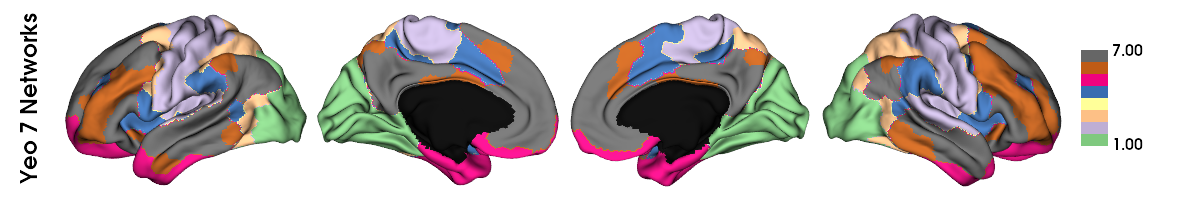

In [8]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [9]:
palette_labeled_networks = {'DMN': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),  # blue
                            'dorsal attention' : (1.0, 0.4980392156862745, 0.054901960784313725),  # orange
                            'fronto parietal' : (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),  # green
                            'limbic' : (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),  # red  
                            'sensory motor' : (0.5803921568627451, 0.403921568627451, 0.7411764705882353),  # purple
                            'ventral attention' : (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),  # brown
                            'visual' : (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}  # pink

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [10]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [11]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- DMN: 90
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 53


## Functional connectivity matrices (parcellation scheme: Schaefer 400, 7 networks) z-transformed

In [12]:
# define the path containing the functional connectivity matrices
GSP_path_fc_matrices = datadir+'fc_matrices/GSP/functional_schaefer400/'

# fetch the functional connectivity matrices of all subjects 
GSP_all_sub_fc_matrices = fetch_all_sub_conn_matrices(GSP_path_fc_matrices)

# store the functional connectivity matrices and subject list in respecive variables
GSP_fc_matrices = GSP_all_sub_fc_matrices['conn_matrices']
GSP_sub_list = GSP_all_sub_fc_matrices['sub_list']

Connectivity matrices found in path /data/p_02667/sex_diff_gradients/data/fc_matrices/GSP/functional_schaefer400/: N = 1568


In [13]:
# define the path containing the functional connectivity matrices
HCP_path_fc_matrices = datadir+'fc_matrices/HCP/functional_schaefer400/mean/'

# fetch the functional connectivity matrices of all subjects 
HCP_all_sub_fc_matrices = fetch_all_sub_conn_matrices(HCP_path_fc_matrices)

# store the functional connectivity matrices and subject list in respecive variables
HCP_fc_matrices = HCP_all_sub_fc_matrices['conn_matrices']
HCP_sub_list = HCP_all_sub_fc_matrices['sub_list']

Connectivity matrices found in path /data/p_02667/sex_diff_gradients/data/fc_matrices/HCP/functional_schaefer400/mean/: N = 1014


## Descriptive GSP

### Load data

In [14]:
GSP_demographics = pd.read_csv(datadir+'GSP/GSP_list_140630.csv')  
print(f'Sample with demographic data: N = {len(GSP_demographics)}')

#GSP_demographics.keys()

Sample with demographic data: N = 1570


In [15]:
GSP_demographics

Subject_ID Subject_Rescan_ID  MRI Behavior Sex  Age_Bin Hand  Educ  \
0     Sub0001_Ses1               NaN    2   Absent   F       25  RHT    16   
1     Sub0002_Ses1               NaN    1  Present   F       23  RHT    16   
2     Sub0003_Ses1               NaN    2   Absent   M       19  RHT    14   
3     Sub0004_Ses1               NaN    2  Present   F       27  RHT    18   
4     Sub0005_Ses1               NaN    1   Absent   F       21  RHT    15   
...            ...               ...  ...      ...  ..      ...  ...   ...   
1565  Sub1566_Ses1               NaN    1   Absent   M       23  RHT    15   
1566  Sub1567_Ses1               NaN    1   Absent   M       25  RHT    16   
1567  Sub1568_Ses1               NaN    1   Absent   M       21  RHT    15   
1568  Sub1569_Ses1               NaN    1   Absent   M       19  RHT    12   
1569  Sub1570_Ses1               NaN    2  Present   F       21  RHT    15   

     Race_Ethn Scanner_Bin  ... R_Parahipp_Thick L_Parahipp_Thick  \
0     W_NOT_HL           E  ...            2.889            2.414   
1     W_NOT_HL           B  ...            2.912            2.697   
2        Other           E  ...            2.559            2.644   
3     W_NOT_HL           B  ...            2.789            2.781   
4        Other           E  ...            2.817            2.919   
...        ...         ...  ...              ...              ...   
1565  W_NOT_HL           E  ...            2.436            2.160   
1566  W_NOT_HL           D  ...            2.537            2.719   
1567  W_NOT_HL           E  ...            2.773            3.004   
1568  W_NOT_HL           E  ...            2.613            2.921   
1569  W_NOT_HL           E  ...            2.241            2.065   

      R_Fform_Thick  L_Fform_Thick  R_supF_Thick  L_supF_Thick  R_iPar_Thick  \
0             2.825          2.687         2.726         2.809         2.459   
1             2.784          2.721         2.948         2.945         2.509   
2             2.794          2.691         2.950         2.966         2.399   
3             2.746          2.605         2.971         2.971         2.530   
4             2.901          2.741         3.041         3.229         2.611   
...             ...            ...           ...           ...           ...   
1565          2.676          2.793         2.700         2.760         2.399   
1566          2.717          2.657         2.720         2.773         2.382   
1567          2.673          2.610         2.752         2.835         2.395   
1568          2.733          2.739         2.621         2.755         2.625   
1569          2.695          2.595         2.759         2.850         2.481   

      L_iPar_Thick  R_Ins_Thick  L_Ins_Thick  
0            2.394        3.354        3.057  
1            2.489        3.347        3.506  
2            2.450        3.226        3.286  
3            2.348        3.195        3.097  
4            2.476        3.387        3.267  
...            ...          ...          ...  
1565         2.209        3.291        3.251  
1566         2.282        3.238        3.461  
1567         2.394        3.372        3.129  
1568         2.591        3.405        3.463  
1569         2.286        3.287        3.190  

[1570 rows x 88 columns]

### Making "cleaned" version of the demographics dataframe which only contains subjects who also have fc matrices

In [17]:
# making a list of only the numbers of subjects with fc matrices 
GSP_sub_list_numbers = []

for sub in GSP_sub_list:
    GSP_sub_list_numbers.append(sub[4:])
    
    
# create a new "cleaned" variable and set index as subject in order to drop subject rows by calling on subject ID
GSP_demographics_cleaned = GSP_demographics.set_index('Subject_ID')

# 2 subjects with fc matrices missing: 0008 and 1287
for subID in GSP_demographics.loc[:,'Subject_ID']:
    if str(str(subID)[3:7]) not in GSP_sub_list_numbers:
        GSP_demographics_cleaned = GSP_demographics_cleaned.drop(subID)

In [18]:
print(f"N = {len(GSP_demographics_cleaned)}\n"
      f"{np.sum(GSP_demographics_cleaned.Sex == 'F')} females, {np.sum(GSP_demographics_cleaned.Sex == 'M')} males\n"
      f"Mean subject age: {np.mean(GSP_demographics_cleaned.Age_Bin):.2f}, SD: {np.std(GSP_demographics_cleaned.Age_Bin):.2f}, range: {np.min(GSP_demographics_cleaned.Age_Bin):.2f} - {np.max(GSP_demographics_cleaned.Age_Bin):.2f}\n"
      f"Mean ICV: {np.mean(GSP_demographics_cleaned.ICV):.2f}, SD: {np.std(GSP_demographics_cleaned.ICV):.2f}, range: {np.min(GSP_demographics_cleaned.ICV):.2f} - {np.max(GSP_demographics_cleaned.ICV):.2f}")

N = 1568
905 females, 663 males
Mean subject age: 21.54, SD: 2.89, range: 19.00 - 35.00
Mean ICV: 1550645.44, SD: 148622.46, range: 1128895.08 - 2028048.55


### Export demographics dataframe to csv for R analyses

In [165]:
GSP_demographics_cleaned.to_csv(resdir_gsp+'demographics_cleaned.csv', header = True, index = True)

### Testing differences in age between the sexes (given that I will test sex differences without matching for age)

In [20]:
# Levene's test for equality of variances -> non-significant differences means equality, can contiunue with parametric independent samples t-test
stats.levene(GSP_demographics_cleaned.Age_Bin[GSP_demographics_cleaned.Sex == 'M'], GSP_demographics_cleaned.Age_Bin[GSP_demographics_cleaned.Sex == 'F'])

LeveneResult(statistic=0.9402326681380857, pvalue=0.3323677474311486)

In [21]:
stats.ttest_ind(GSP_demographics_cleaned.Age_Bin[GSP_demographics_cleaned.Sex == 'M'], GSP_demographics_cleaned.Age_Bin[GSP_demographics_cleaned.Sex == 'F'])

Ttest_indResult(statistic=1.283186804764, pvalue=0.19961650062768793)

Text(0, 0.5, 'Frequency')

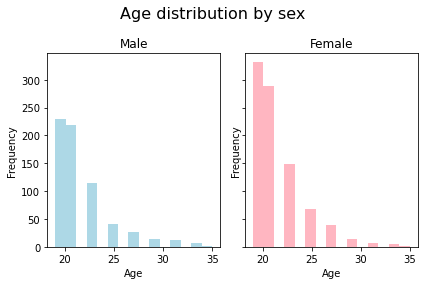

In [22]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Age distribution by sex', fontsize=16)

axs[0].hist(GSP_demographics_cleaned.Age_Bin[GSP_demographics_cleaned.Sex == 'M'], bins=15, color = 'lightblue')
axs[0].set_title('Male')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].hist(GSP_demographics_cleaned.Age_Bin[GSP_demographics_cleaned.Sex == 'F'], bins=15, color = 'lightpink')
axs[1].set_title('Female')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

## Descriptive HCP

### Load data

In [268]:
restricted_data = pd.read_csv(datadir+'RESTRICTED_wanb_9_29_2020_2_14_36.csv')  # contains ACTUAL age, race, ethnicity, handedness, income, education, menstrual cycle info
print(f'Sample with demographic (restricted) data: N = {len(restricted_data)}')

#restricted_data.keys()
#for i in restricted_data.keys():
#    print(i)

unrestricted_data = pd.read_csv(datadir+'unrestricted_wanb_9_14_2020_7_53_51.csv')  # sex ('gender'), BINNED age (in 5-year increments, 22-25, 26-30, 31-35, 35+), ICV ('FS_IntraCranial_Vol')
print(f'Sample with demographic (unrestricted) data: N = {len(unrestricted_data)}')

#unrestricted_data.keys
#for i in unrestricted_data.keys():
#    print(i)

Sample with demographic (restricted) data: N = 1206
Sample with demographic (unrestricted) data: N = 1206


### Making "cleaned" versions of the dataframes which only contain subjects who also have fc matrices

In [269]:
## restricted data

# set index as subject in order to drop subject rows by calling on subject ID
restricted_data_cleaned = restricted_data.set_index('Subject')

for subID in restricted_data.loc[:,'Subject']:
    if str(subID) not in HCP_sub_list:
        restricted_data_cleaned = restricted_data_cleaned.drop(subID)
        
        
## unrestricted data

# set index as subject in order to drop subject rows by calling on subject ID
unrestricted_data_cleaned = unrestricted_data.set_index('Subject')

for subID in unrestricted_data.loc[:,'Subject']:
    if str(subID) not in HCP_sub_list:
        unrestricted_data_cleaned = unrestricted_data_cleaned.drop(subID)

### Creating a merged demographic dataframe (from restricted and unrestricted data)

In [270]:
# merge based on index of both left dataset (unrestricted) and right dataset (restricted)
HCP_demographics_cleaned = pd.merge(unrestricted_data_cleaned, restricted_data_cleaned, left_index=True, right_index=True)

### Creating a variable describing twin status (MZ, DZ, sibling, unrelated)

#### This is for linear mixed effect model -> controling for family and twin status 

In [271]:
### Make a list containing the family IDs that have multiple siblings

HCP_family_IDs = []  # contains all family IDs (without duplicates)
HCP_family_IDs_related = []  # contains family IDs of subjects that have relatives in sample ("duplicated" family IDs) - each ID appearing only 1x

# loop over all subjects
for i in range(len(HCP_demographics_cleaned)):
   
    # conditions to append family ID in HCP_family_IDs_related df:
    # if the current sub's family ID is already in the HCP_family_IDs, it means that we have looped over this family ID before therefore there are siblings sharing this family_ID in the dataset; AND
    # because we don't want duplicate family IDs in HCP_family_IDs_related: if the current sub's family ID is not yet in HCP_family_IDs_related -> we need to append it
    if (HCP_demographics_cleaned.Family_ID.iloc[i] in HCP_family_IDs) & (HCP_demographics_cleaned.Family_ID.iloc[i] not in HCP_family_IDs_related):
        HCP_family_IDs_related.append(HCP_demographics_cleaned.Family_ID.iloc[i])
    
    if HCP_demographics_cleaned.Family_ID.iloc[i] not in HCP_family_IDs: 
        HCP_family_IDs.append(HCP_demographics_cleaned.Family_ID.iloc[i])
        
        
        
### create a list containing (in order of participants) those that have other family members in the sample based on their family ID (if it is present in list HCP_family_IDs_related)

family_members_in_sample = []

for i in HCP_demographics_cleaned['Family_ID'] :
    if i in HCP_family_IDs_related:
        family_members_in_sample.append(1)
    else:
        family_members_in_sample.append(0)



### create a new variable variable that specifies the twin status (i.e., MZ, DZ, sibling, unrelated)
# based on family_members_in_sample and Zygosity variables 
    # ZygosityGT (determined via genotyping) should be given precedence over ZygositySR (self-reported) 
    # Genotyping was only done when both subjects in a twin pair to have HasGT=TRUE to have a value (if genotyping is not available for either of a twin pair, no values are given for ZygosityGT)
    # Non-twin subjects also do not have a value for ZygosityGT
    # Note that some subjects self-reported as dizygotic twins (ZygositySR='NotMZ') but genotyping established that they were monozygotic twins (thence ZygosityGT='MZ' for those subjects)
    # including the empty ZygosityGT condition so that ZygositySR does not override GT    

TwinStatus = []

for i in range(len(HCP_demographics_cleaned)):
    if family_members_in_sample[i] == 1:
        if HCP_demographics_cleaned.ZygosityGT.iloc[i] == 'MZ' or (HCP_demographics_cleaned.ZygosityGT.iloc[i] == ' ' and HCP_demographics_cleaned.ZygositySR.iloc[i] == 'MZ'):
            TwinStatus.append('MZ')
        elif HCP_demographics_cleaned.ZygosityGT.iloc[i] == 'DZ' or (HCP_demographics_cleaned.ZygosityGT.iloc[i] == ' ' and HCP_demographics_cleaned.ZygositySR.iloc[i] == 'NotMZ'):
            TwinStatus.append('DZ')
        else:
            TwinStatus.append('sibling')
    elif family_members_in_sample[i] == 0:
        TwinStatus.append('unrelated')

HCP_demographics_cleaned['TwinStatus'] = TwinStatus

In [272]:
print(f"N = {len(HCP_demographics_cleaned)}\n"
      f"{np.sum(HCP_demographics_cleaned.Gender == 'F')} females, {np.sum(HCP_demographics_cleaned.Gender == 'M')} males\n"
      f"Mean subject age: {np.mean(HCP_demographics_cleaned.Age_in_Yrs):.2f}, SD: {np.std(HCP_demographics_cleaned.Age_in_Yrs):.2f}, range: {np.min(HCP_demographics_cleaned.Age_in_Yrs):.2f} - {np.max(HCP_demographics_cleaned.Age_in_Yrs):.2f}\n"
      f"Mean ICV: {np.mean(HCP_demographics_cleaned.FS_IntraCranial_Vol):.2f}, SD: {np.std(HCP_demographics_cleaned.FS_IntraCranial_Vol):.2f}, range: {np.min(HCP_demographics_cleaned.FS_IntraCranial_Vol):.2f} - {np.max(HCP_demographics_cleaned.FS_IntraCranial_Vol):.2f}"
     )

N = 1014
544 females, 470 males
Mean subject age: 28.74, SD: 3.71, range: 22.00 - 37.00
Mean ICV: 1583398.49, SD: 186723.28, range: 831208.30 - 2143193.92


### Export demographics dataframe to csv for R analyses

In [273]:
HCP_demographics_cleaned.to_csv(resdir_hcp+'demographics_cleaned.csv', header = True, index = True)

### Testing differences in age between the sexes (given that I will test sex differences without matching for age)

In [27]:
# Levene's test for equality of variances -> non-significant differences means equality, can contiunue with parametric independent samples t-test
stats.levene(HCP_demographics_cleaned.Age_in_Yrs[HCP_demographics_cleaned.Gender == 'M'], HCP_demographics_cleaned.Age_in_Yrs[HCP_demographics_cleaned.Gender == 'F'])

LeveneResult(statistic=0.14932057395328685, pvalue=0.6992667192352071)

In [28]:
stats.ttest_ind(HCP_demographics_cleaned.Age_in_Yrs[HCP_demographics_cleaned.Gender == 'M'], HCP_demographics_cleaned.Age_in_Yrs[HCP_demographics_cleaned.Gender == 'F'])

Ttest_indResult(statistic=-7.069267321913692, pvalue=2.899004078650321e-12)

Text(0, 0.5, 'Frequency')

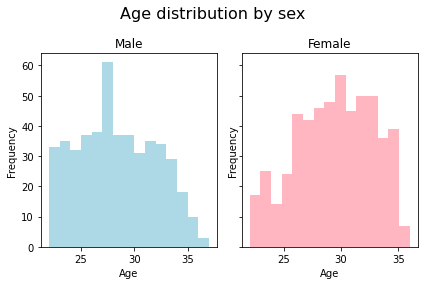

In [29]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Age distribution by sex', fontsize=16)

axs[0].hist(HCP_demographics_cleaned.Age_in_Yrs[HCP_demographics_cleaned.Gender == 'M'], bins=15, color = 'lightblue')
axs[0].set_title('Male')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].hist(HCP_demographics_cleaned.Age_in_Yrs[HCP_demographics_cleaned.Gender == 'F'], bins=15, color = 'lightpink')
axs[1].set_title('Female')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# Computing gradients

## Mean gradients

*Needed for figures and for computing aligned gradients*

### GSP

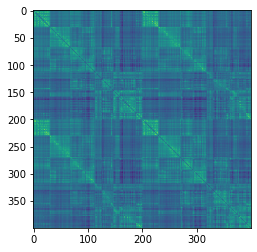

(400, 400)


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


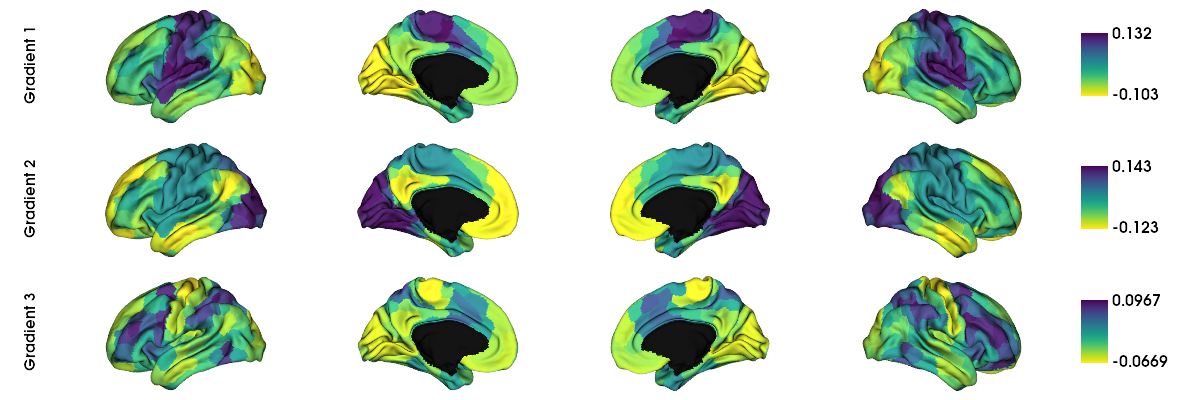

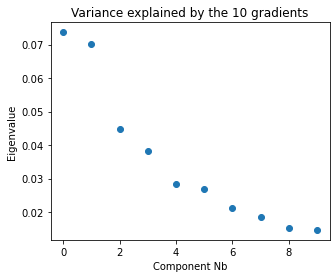

Total amount of variance explained by the 10 gradients (uncorrected sum lambdas): 0.35

Scaled variance explained by individual gradients:
G1: 20.93%
G2: 19.95%
G3: 12.77%



In [30]:
GSP_compute_mean_fc_grad = compute_mean_gradients(GSP_fc_matrices, display_output = True)

# storing the output of the computation of the mean gradients
#GSP_mean_fc_matrix = GSP_compute_mean_fc_grad['mean_conn_matrix']
GSP_mean_fc_grad = GSP_compute_mean_fc_grad['mean_grad']

**From gradient inspection, noticed that Gradient 2 here in GSP data is the unimodal-heteromodal gradient (corresponding to Gradient 1 in HCP and Margulies et al., 2016)**

### HCP

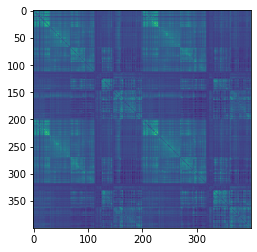

(400, 400)


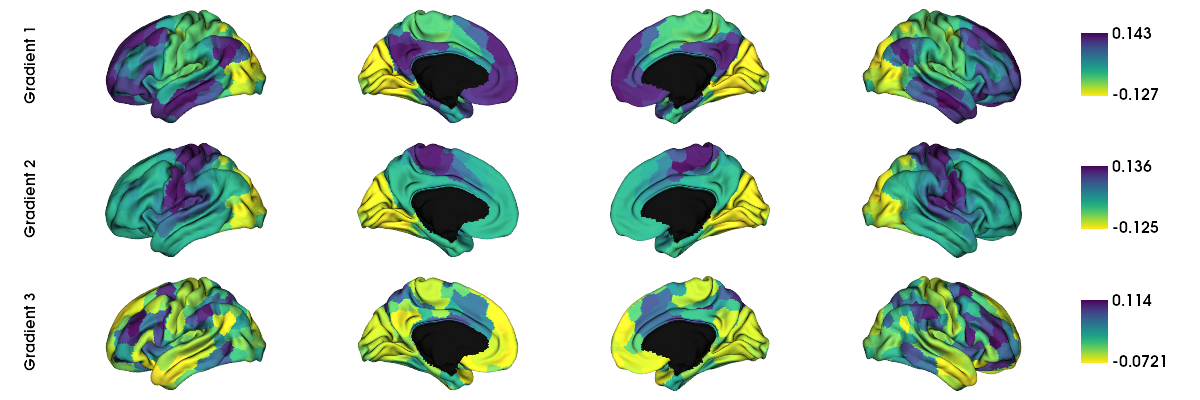

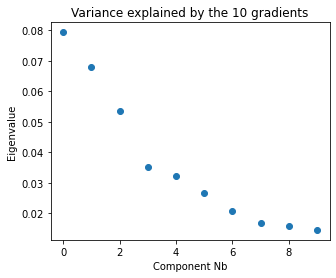

Total amount of variance explained by the 10 gradients (uncorrected sum lambdas): 0.36

Scaled variance explained by individual gradients:
G1: 21.85%
G2: 18.71%
G3: 14.74%



In [31]:
HCP_compute_mean_fc_grad = compute_mean_gradients(HCP_fc_matrices, display_output = True)

# storing the output of the computation of the mean gradients
#HCP_mean_fc_matrix = HCP_compute_mean_fc_grad['mean_conn_matrix']
HCP_mean_fc_grad = HCP_compute_mean_fc_grad['mean_grad']

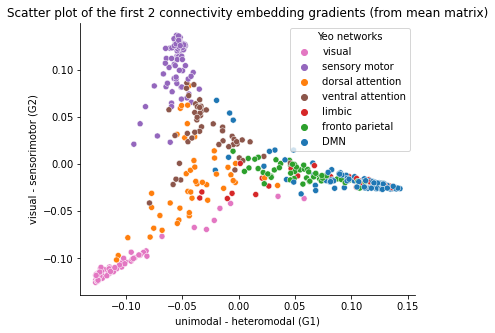

In [32]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=HCP_mean_fc_grad.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=HCP_mean_fc_grad.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)');
ax.set_ylabel('visual - sensorimotor (G2)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

### Post-Hoc changes to GSP mean gradients (G2 sign flip) to make comparable to HCP

**From gradient inspection, noticed that the directionality of Gradient 2 in GSP data (unimodal-heteromodal gradient) does not match that of Gradient 1 in HCP data (unimodal-heteromodal gradient)**


**!!! To make results more easily comparable, creating a new array of mean_grad with a flipped directionality for G2 only (i.e., x -1) !!!**

**!!! Thus: FOR GSP, USE THE RESULTS BELOW !!!**

Explanations
- Flipping directionality is okbecause it doesn't really matter what directionality a gradient has, important is that it has a directionality (it is a gradient)
- It is possible to only flip one gradient because gradients are independent of one another
- Only G2 mean gradient needs to be flipped here because then will do procrustus alignment with new set of mean gradients (only G2 flipped) and all the individual gradients should have this directionality

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


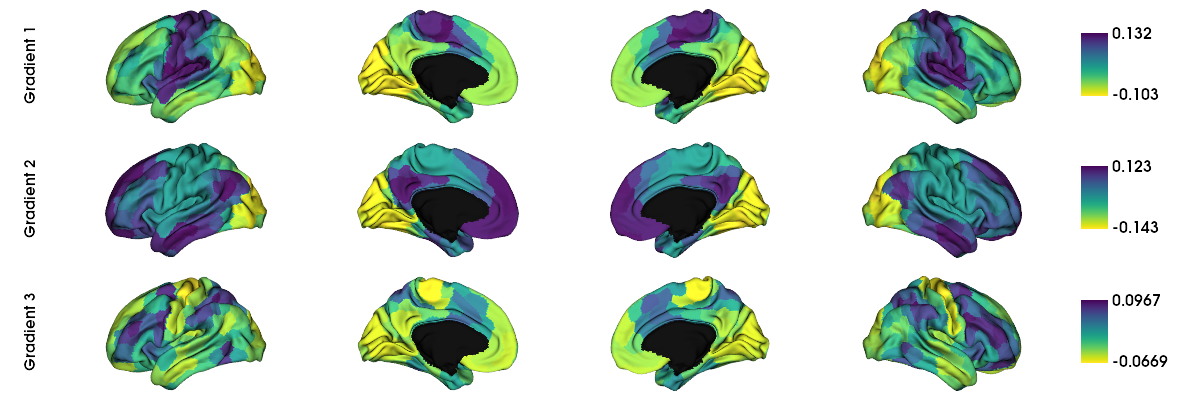

In [33]:
## make a new array for GSP mean gradients that is comparable to the HCP directionality of mean gradients (i.e., need to flip G2)

# list containing gradients matching directionality of HCP gradients (to make results more comparable)
GSP_mean_fc_grad_comparable = []

# counter for iteration
grad_count = 0

# iterating over transposed array of gradients because original shape is (400,10) but it's easier to access G2 from a (10,400) shape 
for grad in GSP_mean_fc_grad.gradients_.T:
    
    grad_count += 1

    # append to GSP_mean_fc_grad_comparable the current gradient - only flip the directionality of G2 (to match G1 HCP), for the rest append as is
    if grad_count == 2:
        GSP_mean_fc_grad_comparable.append(grad*-1)
        
    else:
        GSP_mean_fc_grad_comparable.append(grad)

# need to make gradient list back into an array and transpose it back to initial (400, 10) shape
GSP_mean_fc_grad_comparable = np.array(GSP_mean_fc_grad_comparable).T


## plot the fist three gradients of the new GSP gradient array (i.e., with flipped G2)

# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0


# list containing placeholders (None) for the number of gradients I want to plot
grad = [None] * 3

for i in range(3):
    # map the gradient to the parcels
    grad[i] = map_to_labels((GSP_mean_fc_grad_comparable)[:, i], labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, embed_nb = True, size=(1200, 400), cmap='viridis_r', color_bar=True, label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'], zoom=1.55)

**!! From here on, need to use:**

**GSP_mean_fc_grad_comparable** instead of **GSP_mean_fc_grad_.gradients_ !!** e.g., when using or diplaying mean gradients (on hemispheres or on plot G1 vs G2), or when computing aligned gradients

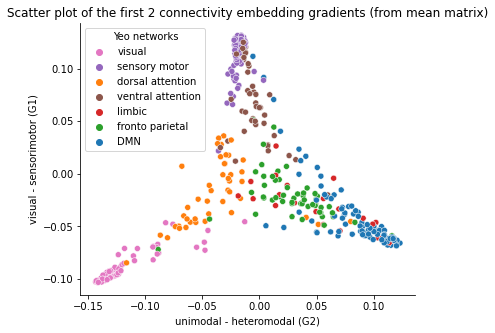

In [34]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable[:,1],  # all rows (400 parcels), second column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable[:,0],  # all rows (400 parcels), first column (G1: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks, 
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - sensorimotor (G1)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

# !!! COMPARISONS hcp / gsp mean gradients -> script in sex_classification
decide if want to keep exporting mean grad (probably not)


## Aligned gradients

Construct gradients for all subjects (procrustes alignment to the overall mean matrix)

In [35]:
GSP_compute_aligned_grad = compute_aligned_gradients(GSP_fc_matrices, GSP_mean_fc_grad_comparable)

# storing the output of the computation of the aligned gradients
#GSP_array_aligned_gradients = GSP_compute_aligned_grad['array_aligned_gradients']
GSP_array_aligned_G1 = GSP_compute_aligned_grad['array_aligned_G1']
GSP_array_aligned_G2 = GSP_compute_aligned_grad['array_aligned_G2']
GSP_array_aligned_G3 = GSP_compute_aligned_grad['array_aligned_G3']

In [36]:
HCP_compute_aligned_grad = compute_aligned_gradients(HCP_fc_matrices, HCP_mean_fc_grad.gradients_)

# storing the output of the computation of the aligned gradients
#HCP_array_aligned_gradients = HCP_compute_aligned_grad['array_aligned_gradients']
HCP_array_aligned_G1 = HCP_compute_aligned_grad['array_aligned_G1']
HCP_array_aligned_G2 = HCP_compute_aligned_grad['array_aligned_G2']
HCP_array_aligned_G3 = HCP_compute_aligned_grad['array_aligned_G3']

### Exporting Gradients to csv for R analyses

In [37]:
# fmt = decimals, header = 1 to 400 (without the first and last string letter because it's the [] of the list, comments = empty because otherwise gives a #

np.savetxt(resdir_gsp+'array_aligned_G1.csv', GSP_array_aligned_G1, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_gsp+'array_aligned_G2.csv', GSP_array_aligned_G2, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_gsp+'array_aligned_G3.csv', GSP_array_aligned_G3, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')

np.savetxt(resdir_hcp+'array_aligned_G1.csv', HCP_array_aligned_G1, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_hcp+'array_aligned_G2.csv', HCP_array_aligned_G2, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_hcp+'array_aligned_G3.csv', HCP_array_aligned_G3, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')

## Mean gradients by sex

*Needed for plotting (mean) Males vs (mean) Females if plan to replicate this figure from Hong et al https://www.nature.com/articles/s41467-019-08944-1/figures/3*

**NEXT STEPS -> see at the bottom of the notebook, attempts to make figure resemble Hong et al.'s:**

### GSP

In [38]:
# creating lists containing only male and only female fc matrices

GSP_fc_matrices_M = []
GSP_fc_matrices_F = []

for i in range(len(GSP_fc_matrices)):
    if GSP_demographics_cleaned.Sex.iloc[i] == "M":
        GSP_fc_matrices_M.append(GSP_fc_matrices[i])
    elif GSP_demographics_cleaned.Sex.iloc[i] == "F":
        GSP_fc_matrices_F.append(GSP_fc_matrices[i])

In [39]:
GSP_compute_mean_fc_grad_M = compute_mean_gradients(GSP_fc_matrices_M, display_output = False)

# storing the output of the computation of the mean gradients
#GSP_mean_fc_matrix_M = GSP_compute_mean_fc_grad_M['mean_conn_matrix']
GSP_mean_fc_grad_M = GSP_compute_mean_fc_grad_M['mean_grad']

In [40]:
GSP_compute_mean_fc_grad_F = compute_mean_gradients(GSP_fc_matrices_F, display_output = False)

# storing the output of the computation of the mean gradients
#GSP_mean_fc_matrix_F = GSP_compute_mean_fc_grad_F['mean_conn_matrix']
GSP_mean_fc_grad_F = GSP_compute_mean_fc_grad_F['mean_grad']

### HCP

In [41]:
# creating lists containing only male and only female fc matrices

HCP_fc_matrices_M = []
HCP_fc_matrices_F = []

for i in range(len(HCP_fc_matrices)):
    if HCP_demographics_cleaned.Gender.iloc[i] == "M":
        HCP_fc_matrices_M.append(HCP_fc_matrices[i])
    elif HCP_demographics_cleaned.Gender.iloc[i] == "F":
        HCP_fc_matrices_F.append(HCP_fc_matrices[i])

In [42]:
HCP_compute_mean_fc_grad_M = compute_mean_gradients(HCP_fc_matrices_M, display_output = False)

# storing the output of the computation of the mean gradients
#HCP_mean_fc_matrix_M = HCP_compute_mean_fc_grad_M['mean_conn_matrix']
HCP_mean_fc_grad_M = HCP_compute_mean_fc_grad_M['mean_grad']

In [43]:
HCP_compute_mean_fc_grad_F = compute_mean_gradients(HCP_fc_matrices_F, display_output = False)

# storing the output of the computation of the mean gradients
#HCP_mean_fc_matrix_F = HCP_compute_mean_fc_grad_F['mean_conn_matrix']
HCP_mean_fc_grad_F = HCP_compute_mean_fc_grad_F['mean_grad']

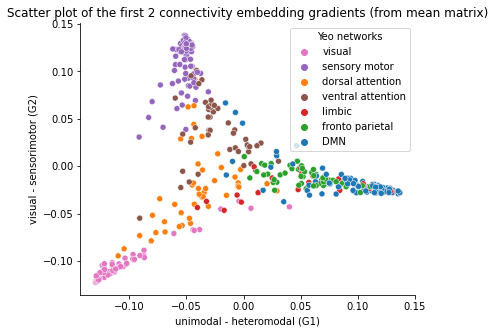

In [44]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=HCP_mean_fc_grad_M.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=HCP_mean_fc_grad_M.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)');
ax.set_ylabel('visual - sensorimotor (G2)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

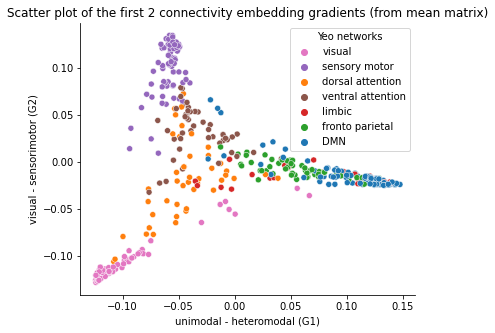

In [45]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=HCP_mean_fc_grad_F.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=HCP_mean_fc_grad_F.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)');
ax.set_ylabel('visual - sensorimotor (G2)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

### Post-Hoc changes to GSP mean gradients (G2 sign flip) to make comparable to HCP

Again need to flip G2 directionality in males and females separately

In [46]:
# list containing gradients matching directionality of HCP gradients (to make results more comparable)
GSP_mean_fc_grad_comparable_M = []
GSP_mean_fc_grad_comparable_F = []


## Males

# counter for iteration
grad_count = 0

# iterating over transposed array of gradients because original shape is (400,10) but it's easier to access G2 from a (10,400) shape 
for grad in GSP_mean_fc_grad_M.gradients_.T:
    
    grad_count += 1

    # append to mean_grad_hcp_directionality the current gradient - only flip the directionality of G2 (to match G1 HCP), for the rest append as is
    if grad_count == 2:
        GSP_mean_fc_grad_comparable_M.append(grad*-1)
        
    else:
        GSP_mean_fc_grad_comparable_M.append(grad)

# need to make gradient list back into an array and transpose it back to initial (400, 10) shape
GSP_mean_fc_grad_comparable_M = np.array(GSP_mean_fc_grad_comparable_M).T


## Females

# counter for iteration
grad_count = 0

# iterating over transposed array of gradients because original shape is (400,10) but it's easier to access G2 from a (10,400) shape 
for grad in GSP_mean_fc_grad_F.gradients_.T:
    
    grad_count += 1

    # append to mean_grad_hcp_directionality the current gradient - only flip the directionality of G2 (to match G1 HCP), for the rest append as is
    if grad_count == 2:
        GSP_mean_fc_grad_comparable_F.append(grad*-1)
        
    else:
        GSP_mean_fc_grad_comparable_F.append(grad)

# need to make gradient list back into an array and transpose it back to initial (400, 10) shape
GSP_mean_fc_grad_comparable_F = np.array(GSP_mean_fc_grad_comparable_F).T

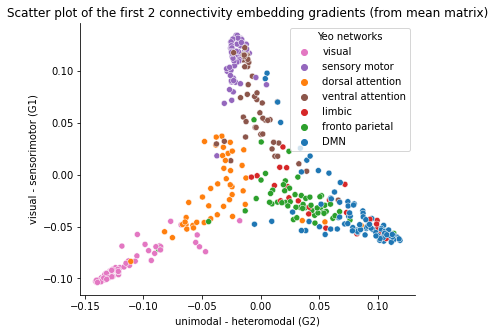

In [47]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable_M[:,1],  # all rows (400 parcels), second column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable_M[:,0],  # all rows (400 parcels), first column (G1: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks, 
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - sensorimotor (G1)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

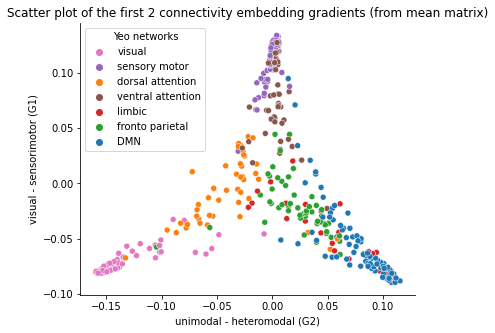

In [48]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable_F[:,1],  # all rows (400 parcels), second column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable_F[:,0],  # all rows (400 parcels), first column (G1: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks, 
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - sensorimotor (G1)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

Visualiasation of the first three gradients in males and females with flipped G2 (comparable to HCP's G1)

# Visualizing gradients by network (and sex)

Using RainCloud plots https://github.com/RainCloudPlots/RainCloudPlots#python-environment

**CURRENT THING TO WATCH OUT FOR IN PLOT INTERPRETATION: sex (M v F) order in plots (top v bottom) currently flipped for GSP and HCP displays -> not ideal for comparing across datasets**

**-> if I intend to use these plots in paper, try to find a way to control that M top and F bottom across datasets**

## Unimodal - Heteromodal gradient (G2 GSP; G1 HCP)

### GSP

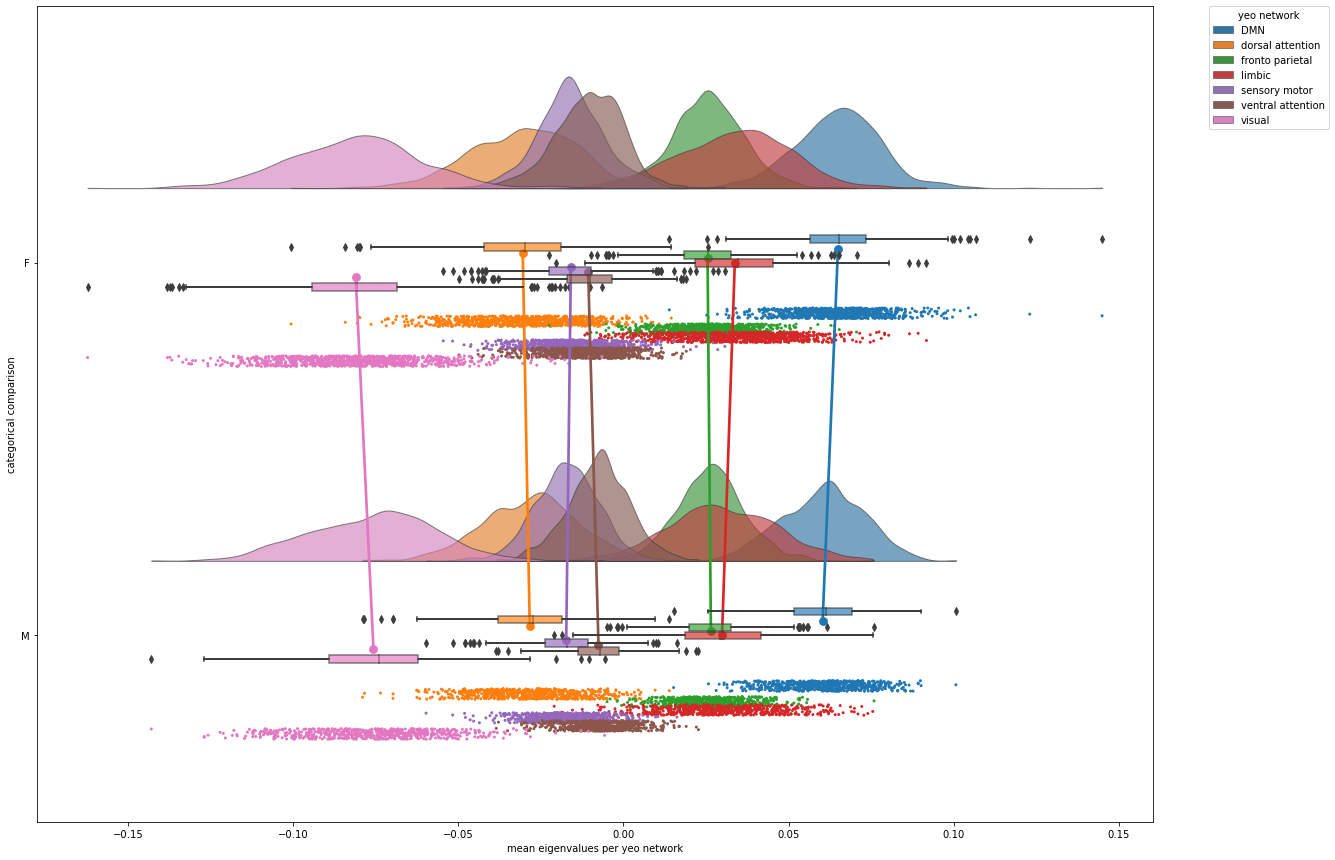

In [49]:
RainCloudPlot_YeoNetworks_CategoricalComparison(array_grad = GSP_array_aligned_G2, cat_comp = GSP_demographics_cleaned["Sex"], plot_type = 'by category overlayed')

### HCP

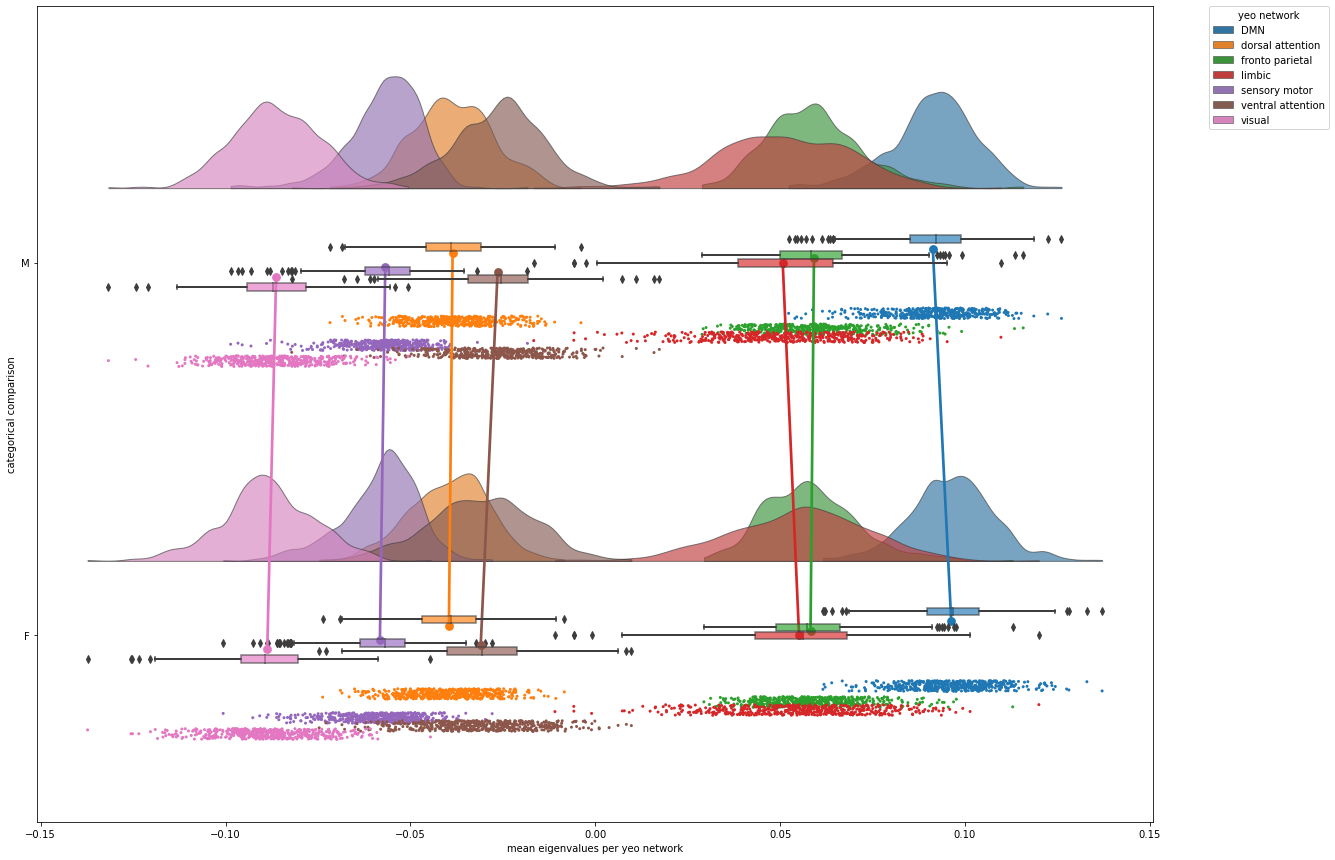

In [50]:
RainCloudPlot_YeoNetworks_CategoricalComparison(array_grad = HCP_array_aligned_G1, cat_comp = HCP_demographics_cleaned["Gender"], plot_type = 'by category overlayed')

## Visual - Sensorimotor gradient (G1 GSP; G2 HCP)

### GSP

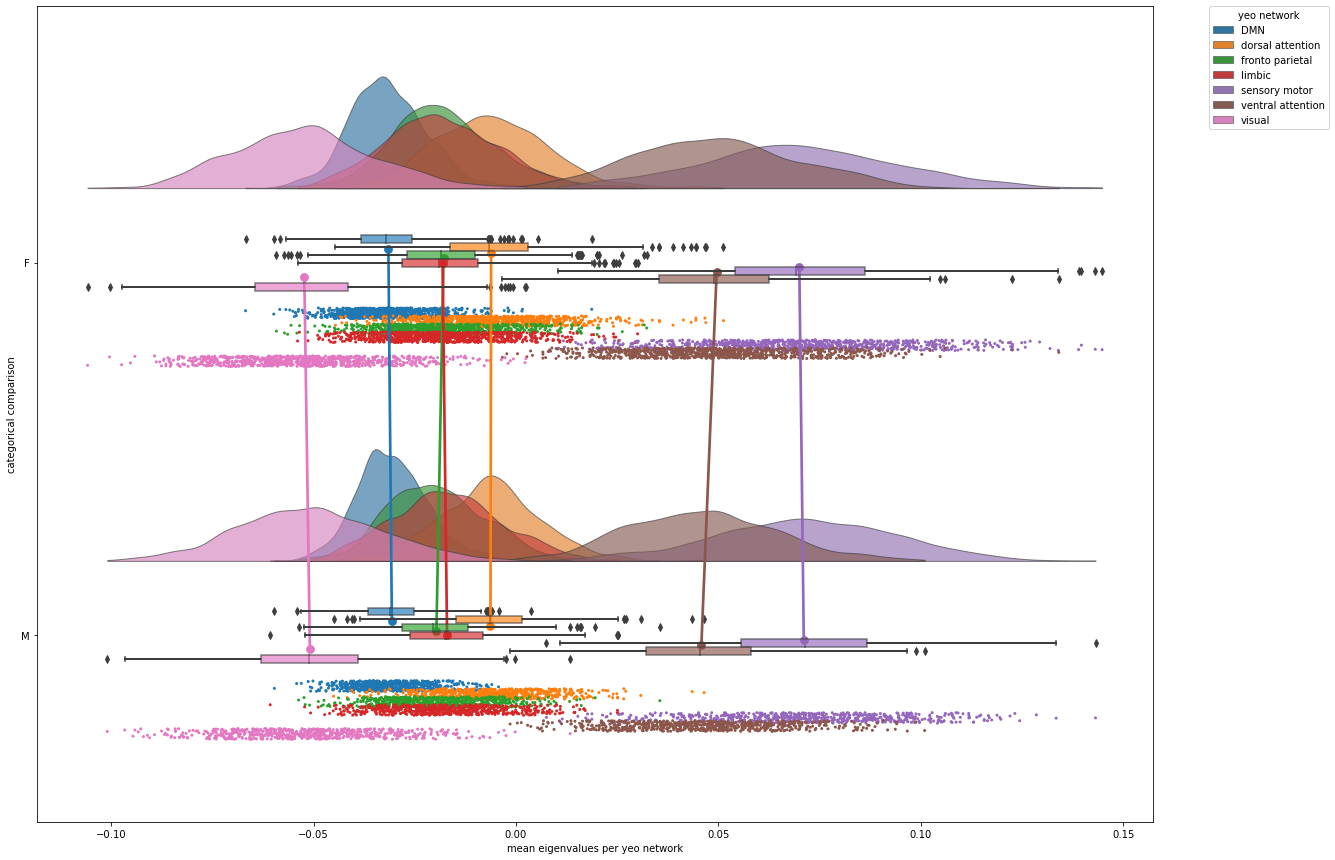

In [51]:
RainCloudPlot_YeoNetworks_CategoricalComparison(array_grad = GSP_array_aligned_G1, cat_comp = GSP_demographics_cleaned["Sex"], plot_type = 'by category overlayed')

### HCP

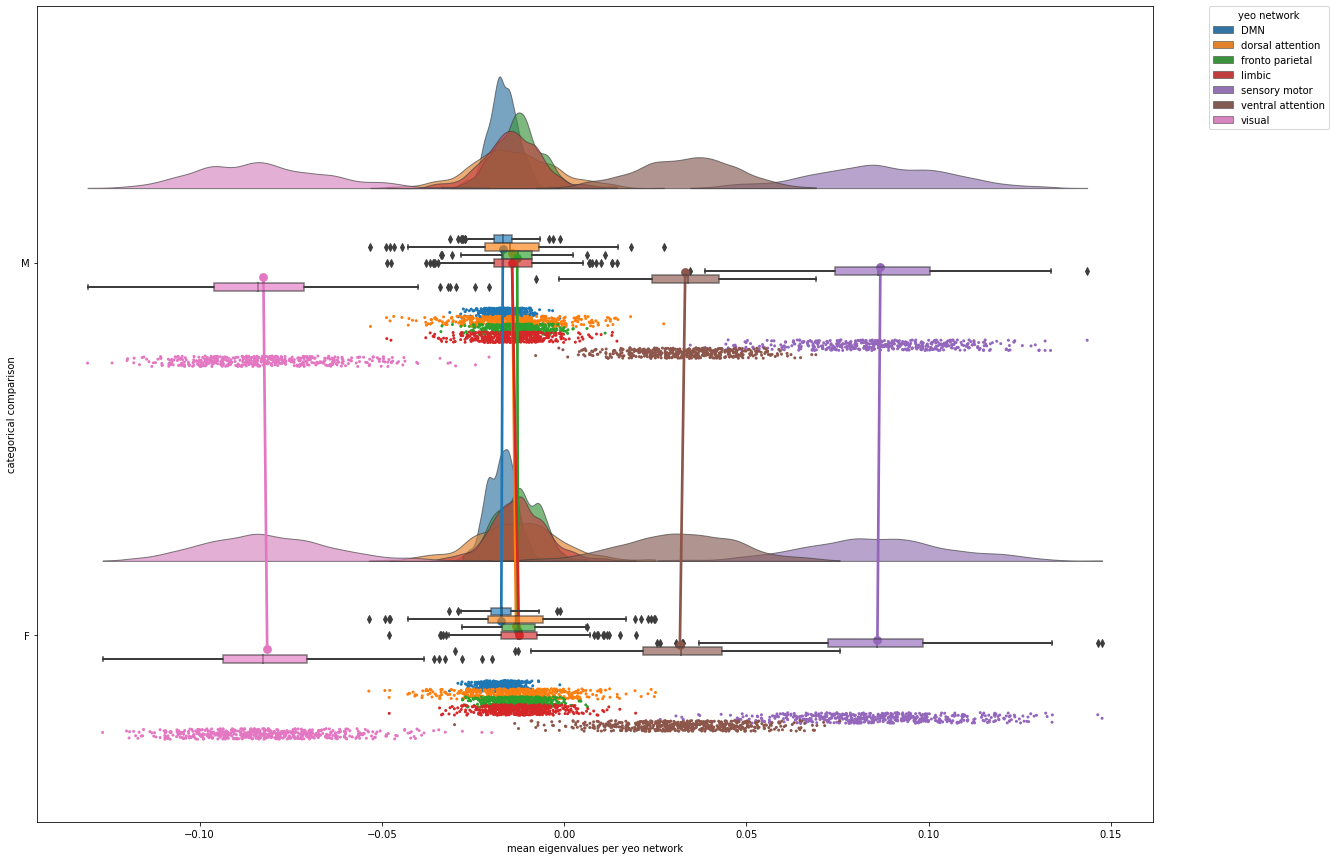

In [52]:
RainCloudPlot_YeoNetworks_CategoricalComparison(array_grad = HCP_array_aligned_G2, cat_comp = HCP_demographics_cleaned["Gender"], plot_type = 'by category overlayed')

# Sex effects (standard linear regression - FDR-corrected - main model: sex + age + ICV)

In [53]:
def plot_slm_results_R(slm_res_R):
    
    '''
    Function that plots slm results (t-values, p-values, and only FDR corrected q-values)
    
    Input required: slm results dataframe containing vales with the following names: t_val_sex, p_val_sex, q_val_sex (*** HARCODED WITH "sex" IN NAME - CHANGE THIS TO SIMPLY t_val IF I START USING THIS VISUALIZATION FUNCTION FOR OTHER R RESULTS ***)
    
    Specific to plotting on surf_lh, surf_rh from conte69; for data coming from Schaefer 400 parcellation
    
    '''
    
    # defining labeling scheme and mask
    # ! if doesn't work anymore for some reason, take this out of the definition (put it before it) !
    labeling = load_parcellation('schaefer', scale=400, join=True)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0
    
    
    # will contain the different plots
    handles = []
    
    
    ### t-values
    tvals_mapped_to_labels = map_to_labels(np.asarray(slm_res_R.t_val_sex), labeling, mask=mask, fill=np.nan)  # t[0] because there is a double bracket for the t-values array, need [0] to access the values themselves
    
    tvals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = tvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "bwr_r",  # bwr, _r stands for reversed; using it to matche male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["t-values"],
        zoom = 1.45)
    
    # plot
    handles.append(tvals_plotted_hemispheres)
       
        
    
    ### p-values (uncorrected)
    
    #assigning to new variable using copy() so that changes made in copy will not affect the original array
    pvals = np.asarray(slm_res_R.p_val_sex.copy())

    # only keep Q-values that are significant (replacing values > 0.05 with nan)
    np.place(pvals, pvals > 0.05, np.nan) 
    
    # this maps shape (400,) turning it inot shape (64984,)
    pvals_mapped_to_labels = map_to_labels(pvals, labeling, mask=mask, fill=np.nan)
    
    # plot
    pvals_plotted_hemispheres =  plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = pvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "plasma_r", 
        color_bar = True, 
        #color_range = color_range_Q,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["p-values (uncorr.)"],
        zoom = 1.45)
    
    handles.append(pvals_plotted_hemispheres)    
        
        
                   
    ### Q-values
    
    #assigning to new variable using copy() so that changes made in copy will not affect the original array
    Qvals = np.asarray(slm_res_R.q_val_sex.copy())

    # only keep Q-values that are significant (replacing values > 0.05 with nan)
    np.place(Qvals, Qvals > 0.05, np.nan) 
    
    # this maps shape (400,) turning it inot shape (64984,)
    Qvals_mapped_to_labels = map_to_labels(Qvals, labeling, mask=mask, fill=np.nan)
    
    # plot
    Qvals_plotted_hemispheres =  plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = Qvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "plasma_r", 
        color_bar = True, 
        #color_range = color_range_Q,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["Q-values"],
        zoom = 1.45)
    
    handles.append(Qvals_plotted_hemispheres)
                                           
    return handles

In [156]:
def regression_contrast_results_breakdown_by_network(q_values, contrast_type, scatterplot = True, scatter_x = None, scatter_y = None):
    
    '''
    
    Function that outputs the breakdown of regression contrast results by network 
    
    Input:
    - q values (in the format: Pandas Series, i.e., the column of a pd.DataFrame)
    - contrast type: string indicating the contrast that is being studied, e.g., 'sex' (for plot titles)
    - scatter_x: x-axis of the scatterplot G1 vs G2 -> so G1 or G2 from mean gradient (in array format)
    - scatter_y: y-axis of the scatterplot G1 vs G2 -> so G1 or G2 from mean gradient (in array format)
    
    Output (display):  
    - written breakdown (number and proportion of significant parcels by network (relative proportion (i.e., out of all the parcels belonging to a given network) and absolute proportion (i.e., out of the total significant results)
    - plotted breakdown (pie chart) - proportion of significant parcels by network (absolute proportion)
    - scatter plot showing of G1 vs G2, displaying parcels showing a significant contrast in dark
   
    '''
    
    ### written breakdown
    
    # counting number of significant parcels 
    # storing the Q values in a list (where non significant Q values are marked as 1 -> for later potential scatterplot visualization)
    # making a dictionary that counts the number of significant parcels per yeo network

    sig_Q_vals_slm = []
    count_sig = 0
    count_sig_per_network = {"visual": 0, "sensory motor": 0, "DMN": 0, "dorsal attention": 0, "ventral attention": 0, "limbic": 0, "fronto parietal": 0}

    for i in range(len(q_values)):

        if q_values[i] < 0.05:
            count_sig += 1
            count_sig_per_network[yeo7_networks_array_labels[i]] += 1
            #sig_Q_vals_slm.append(q_values[i])
            sig_Q_vals_slm.append(1)
            
        else:
            #sig_Q_vals_slm.append(1)
            sig_Q_vals_slm.append(0)

    print(f"Number of significant parcels: {count_sig}\n")
    print("Number of significant parcels in each Yeo network:")

    # using ANSI escape sequences to underline -> bold: \033[1m ; underline: \033[4m ; end: \033[0m
    for i in range(len(count_sig_per_network)):
        print(f"- {list(count_sig_per_network.keys())[i]}: \033[4m{count_sig_per_network[list(count_sig_per_network.keys())[i]]}\033[0m out of {yeo7_networks_array_labels.tolist().count(network_names[i])} ({round(count_sig_per_network[list(count_sig_per_network.keys())[i]] / yeo7_networks_array_labels.tolist().count(network_names[i]) * 100, 2)}%) -> \033[1m{round(count_sig_per_network[list(count_sig_per_network.keys())[i]]*100/count_sig,2)}%\033[0m of overall significance")
       
    print("\n\n")
    
    
    
    ### plotted breakdown (pie chart)
        
    # setting figure size
    fig, ax = plt.subplots(1, figsize=(10, 7))

    # data to plot: in dictionary count_sig_per_network
    network_labels = []
    data = []

    for x, y in count_sig_per_network.items():
        network_labels.append(x)
        data.append(y)

    # define color palette to use
    color_palette =[(227/255, 174/255, 211/255),  # color palette matching the raincloudplot colors (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt
                    (185/255, 163/255, 204/255),
                    (120/255, 162/255, 189/255),
                    (236/255, 170/255, 119/255),
                    (174/255, 147/255, 143/255),
                    (216/255, 128/255, 129/255),
                    (128/255, 183/255, 126/255)]
    # color_palette = sns.color_palette('pastel')[0:7]  # seaborn pastel color palette

    # plot pie chart
    ax.pie(data, 
           labels = network_labels, colors = color_palette, autopct='%.0f%%', 
           wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
           textprops={'fontsize': 16})

    ax.set_title(f'Breakdown of parcels by network showing a statistically significant {contrast_type} difference in gradient eigenvalues', fontsize=18)

    # display
    ax.axis('equal')
    plt.tight_layout()
    
    
    
    ### plot of significant parcels on G1 vs G2 visualization
    # problems with this plot
        # hard-coded axes labels and title (G1 vs G2)
        # legend of colors: showing 0 vs 1 
    if scatterplot:
    
        fig, ax = plt.subplots(figsize = (6,5));
        ax = sns.scatterplot(x = scatter_x, 
                             y = scatter_y,
                             hue = sig_Q_vals_slm,  # gives color coding based on Q value of sex contrast (main model including age, sex, icv) -> dark color: significance
                             palette = sns.color_palette(["lavender", "navy"]),
                             legend = True, ax = ax);

        ax.set_xlabel('unimodal - heteromodal');
        ax.set_ylabel('visual - sensorimotor ');
        ax.set_title(f'Scatter plot of G1 vs G2, showing significant {contrast_type} contrast in dark')
        ax.spines['right'].set_visible(False);
        ax.spines['top'].set_visible(False);
        #plt.legend(title='1 = FDR-corr significance')
        plt.show(ax)

In [54]:
# loading R results

# GSP model: linear model = Gradient_Eigenvalues ~ Sex + Age + ICV 
GSP_R_lm_G1_res = pd.read_csv(resdir_gsp+'R_lm_G1_res.csv')  
GSP_R_lm_G2_res = pd.read_csv(resdir_gsp+'R_lm_G2_res.csv')  
GSP_R_lm_G3_res = pd.read_csv(resdir_gsp+'R_lm_G3_res.csv')  

# HCP model: linear mixed effects model = 

## Unimodal - Heteromodal gradient (G2 GSP; G1 HCP)

### GSP

Number of significant parcels: 105

Number of significant parcels in each Yeo network:
- visual: 19 out of 61 (31.15%) -> 18.1% of overall significance
- sensory motor: 3 out of 77 (3.9%) -> 2.86% of overall significance
- DMN: 33 out of 90 (36.67%) -> 31.43% of overall significance
- dorsal attention: 5 out of 46 (10.87%) -> 4.76% of overall significance
- ventral attention: 20 out of 47 (42.55%) -> 19.05% of overall significance
- limbic: 11 out of 26 (42.31%) -> 10.48% of overall significance
- fronto parietal: 14 out of 53 (26.42%) -> 13.33% of overall significance





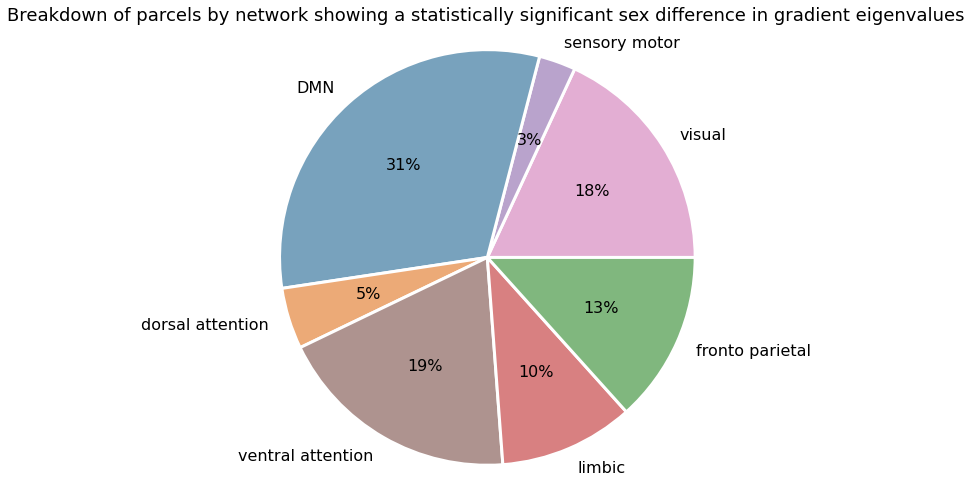

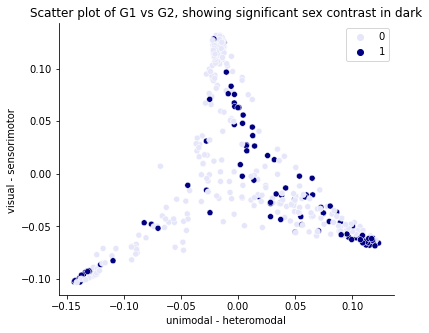

In [163]:
regression_contrast_results_breakdown_by_network(GSP_R_lm_G2_res.q_val_sex, contrast_type = 'sex', scatter_x = GSP_mean_fc_grad_comparable[:,1], scatter_y = GSP_mean_fc_grad_comparable[:,0])

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


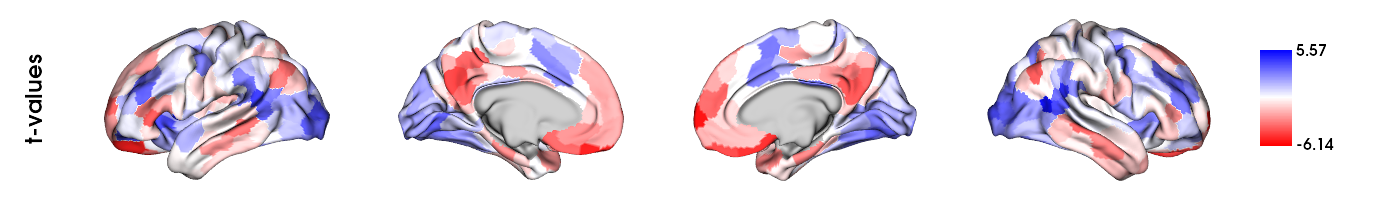

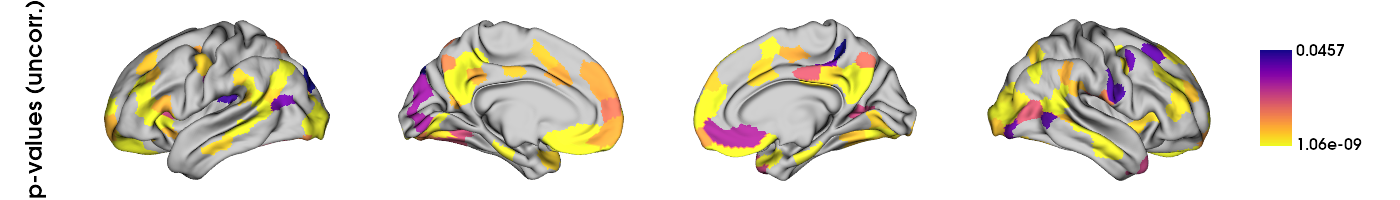

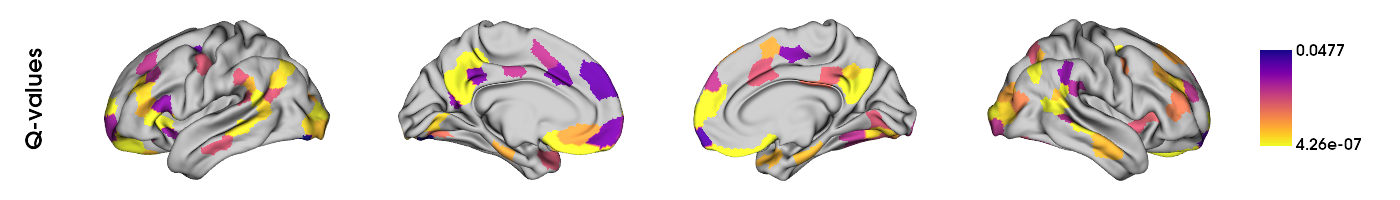

In [164]:
plots_to_display = plot_slm_results_R(GSP_R_lm_G2_res)
display(*plots_to_display)

### HCP

## Visual - Sensorimotor gradient (G1 GSP; G2 HCP)

### GSP

Number of significant parcels: 37

Number of significant parcels in each Yeo network:
- visual: 0 out of 61 (0.0%) -> 0.0% of overall significance
- sensory motor: 2 out of 77 (2.6%) -> 5.41% of overall significance
- DMN: 10 out of 90 (11.11%) -> 27.03% of overall significance
- dorsal attention: 1 out of 46 (2.17%) -> 2.7% of overall significance
- ventral attention: 17 out of 47 (36.17%) -> 45.95% of overall significance
- limbic: 3 out of 26 (11.54%) -> 8.11% of overall significance
- fronto parietal: 4 out of 53 (7.55%) -> 10.81% of overall significance





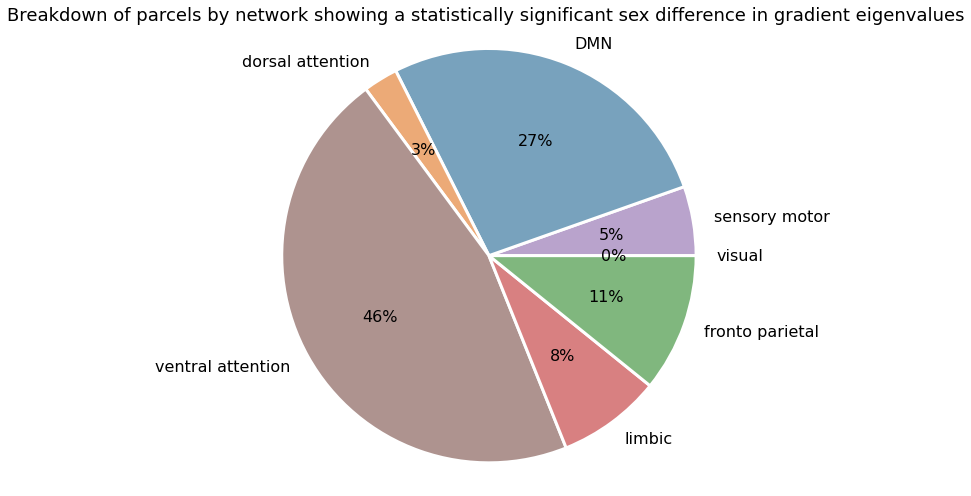

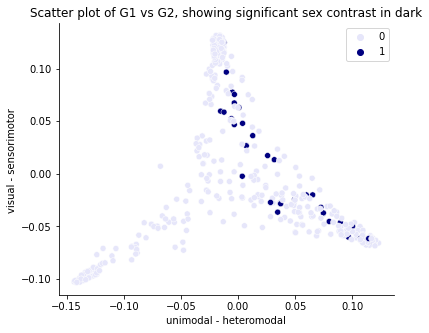

In [157]:
regression_contrast_results_breakdown_by_network(GSP_R_lm_G1_res.q_val_sex, contrast_type = 'sex', scatter_x = GSP_mean_fc_grad_comparable[:,1], scatter_y = GSP_mean_fc_grad_comparable[:,0])

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


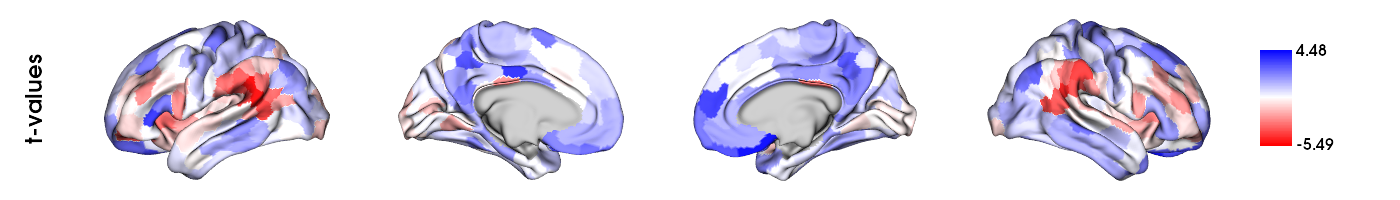

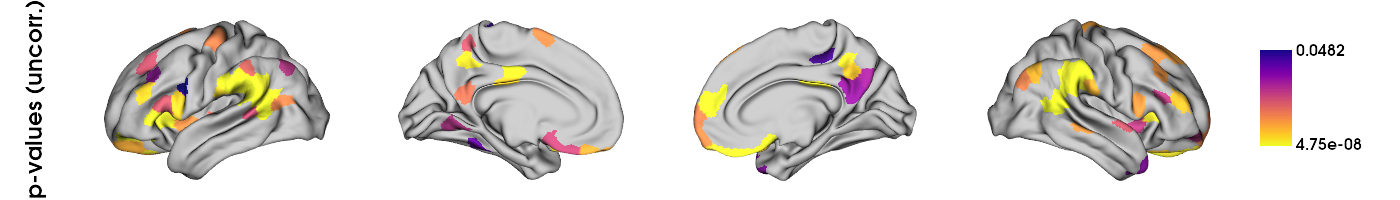

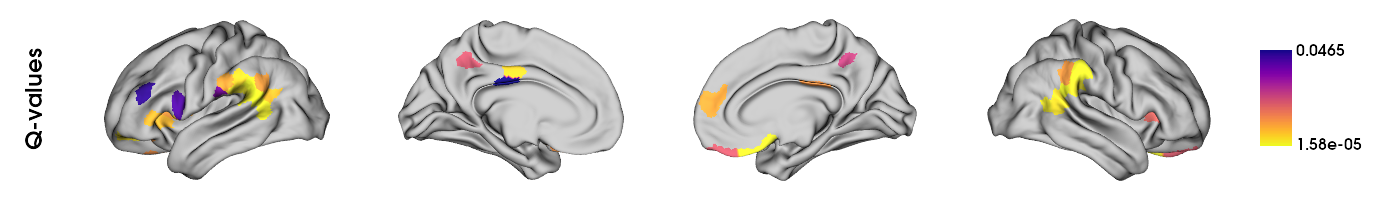

In [114]:
plots_to_display = plot_slm_results_R(GSP_R_lm_G1_res)
display(*plots_to_display)

### HCP

## Gradient 3

### GSP

Number of significant parcels: 26

Number of significant parcels in each Yeo network:
- visual: 1 out of 61 (1.64%) -> 3.85% of overall significance
- sensory motor: 2 out of 77 (2.6%) -> 7.69% of overall significance
- DMN: 3 out of 90 (3.33%) -> 11.54% of overall significance
- dorsal attention: 6 out of 46 (13.04%) -> 23.08% of overall significance
- ventral attention: 3 out of 47 (6.38%) -> 11.54% of overall significance
- limbic: 6 out of 26 (23.08%) -> 23.08% of overall significance
- fronto parietal: 5 out of 53 (9.43%) -> 19.23% of overall significance





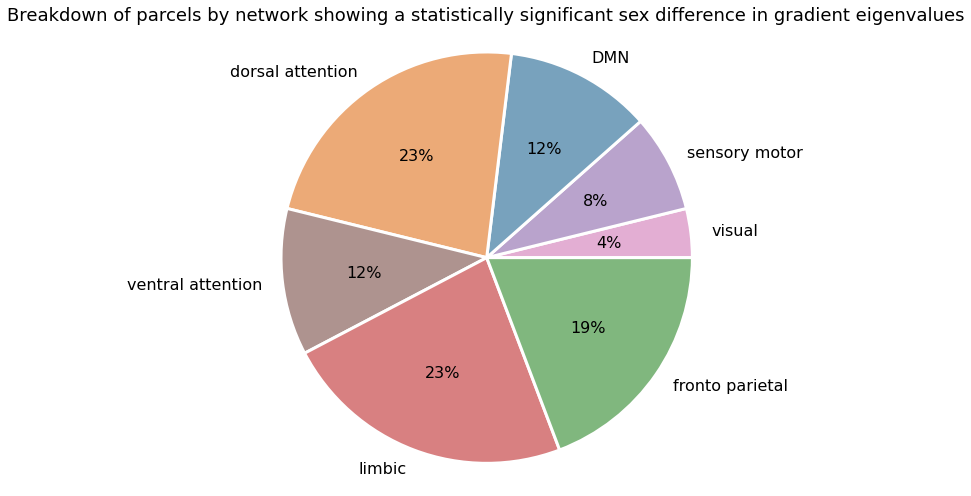

In [162]:
regression_contrast_results_breakdown_by_network(GSP_R_lm_G3_res.q_val_sex, contrast_type = 'sex', scatterplot = False) 
# not displaying scatterplot because labels hardcoded for G1 vs G2 (and it does not make sense to do that for G3 signficance)

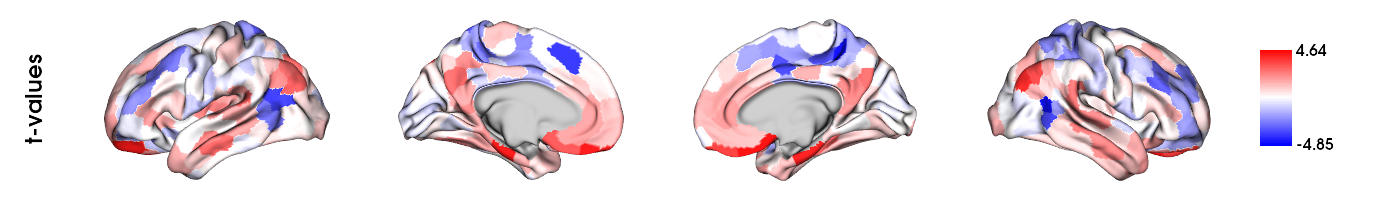

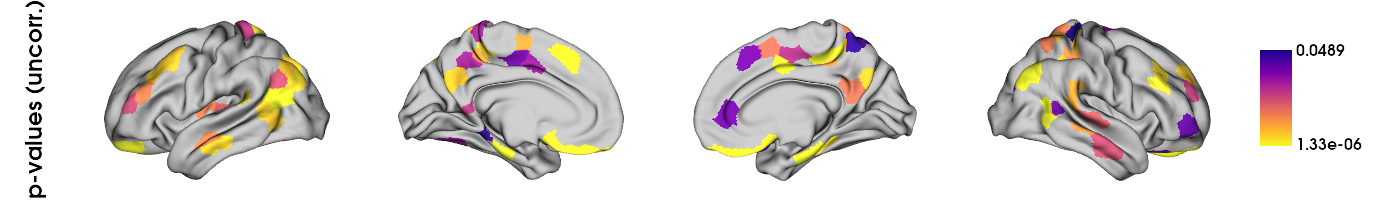

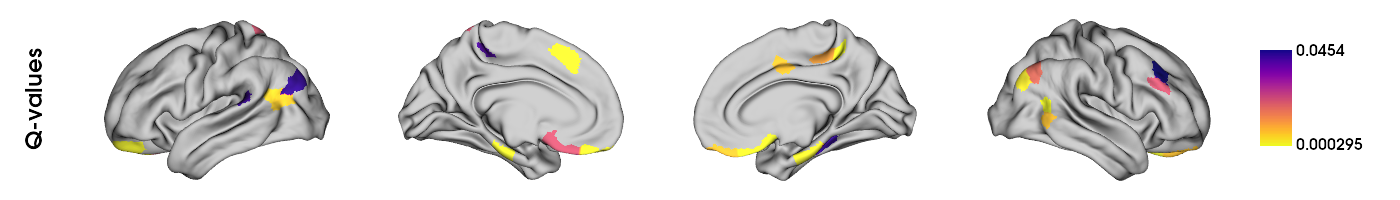

In [127]:
plots_to_display = plot_slm_results_R(R_lm_G3_sex_age_icv_res)
display(*plots_to_display)

### HCP

#
#
#
#
#
#
# TO DO Visualizing sex differences in gradients

## TO DO: Goal is to replicate this figure from Hong et al https://www.nature.com/articles/s41467-019-08944-1/figures/3

**NEXT STEPS:**
- Put Males and Females side by side
- Try quiver plots to show movements of t values https://pythonforundergradengineers.com/quiver-plot-with-matplotlib-and-jupyter-notebooks.html

Preparing colorcoding for plots

**TO DO: FIND OTHER COLOR NAMES??** could only find sns color maps but not individual names...

In [71]:
# dictionary color palette emphasizing visual, sensory motore, and DMN networks
palette_visual_sensmotor_DMN = {"visual":"tab:cyan",
                                "sensory motor":"tab:orange", 
                                "DMN":"tab:purple",
                                
                                "dorsal attention":"tab:grey",
                                "ventral attention":"tab:grey",
                                "limbic":"tab:grey",
                                "fronto parietal":"tab:grey"}

Color-coding all networks

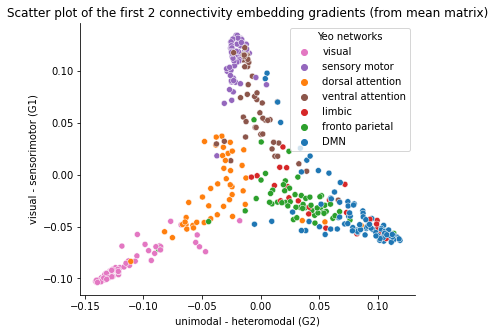

In [68]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable_M[:,1],  # all rows (400 parcels), second column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable_M[:,0],  # all rows (400 parcels), first column (G1: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks, 
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - sensorimotor (G1)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

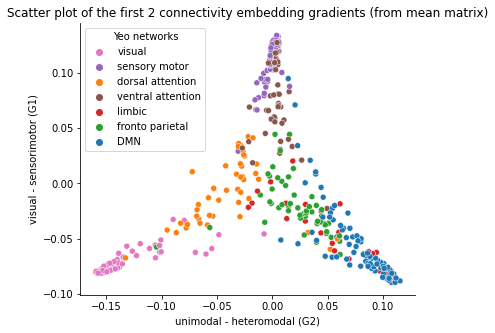

In [69]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable_F[:,1],  # all rows (400 parcels), second column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable_F[:,0],  # all rows (400 parcels), first column (G1: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks, 
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - sensorimotor (G1)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

Color-coding only networks at G1-G2 extremities (visual, sensorymotor, DMN)

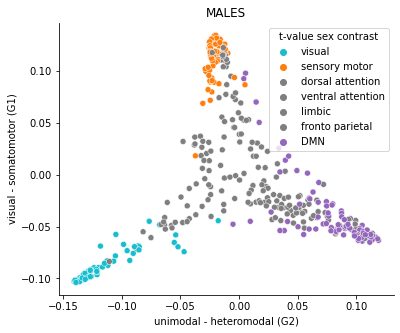

In [72]:
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable_M[:,1],  # all rows (400 parces), first column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable_M[:,0],  # all rows (400 parces), second column (G1: visual - somatomotor)  
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks (only visual, sensory motore, DMN)
                     palette=palette_visual_sensmotor_DMN,                    
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - somatomotor (G1)');
ax.set_title("MALES")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='t-value sex contrast')
plt.show(ax)

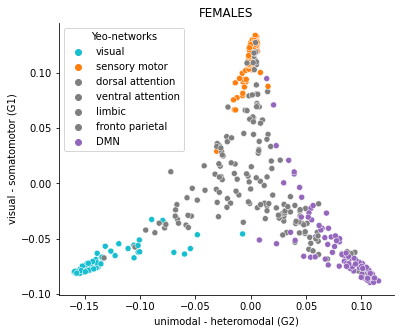

In [73]:
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable_F[:,1],  # all rows (400 parces), first column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable_F[:,0],  # all rows (400 parces), second column (G1: visual - somatomotor)  
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks (only visual, sensory motore, DMN)
                     palette=palette_visual_sensmotor_DMN,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - somatomotor (G1)');
ax.set_title("FEMALES")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo-networks')
plt.show(ax)

Scatter plots of the first 2 gradients, color coding shows t-values (**but categorical colorcoding -> NEED TO FIND A WAY TO DO IT CONTINOUS!!**)

*this was asked by Sofie, not replication of Hong et al.*

**TO DO: TROUBLESHOOTING CONTINOUS COLOR CODING**

- asked sofie if Hong's exact code is available anywhere
- can try using a different package for scatter (and not sns, e.g. https://stackoverflow.com/questions/12965075/matplotlib-scatter-plot-colour-as-function-of-third-variable specifically look for packages that will allow to color as a function of a third CONTINUOUS variable)
- ask Bin / Seyma for help?


**TO DO: WHEN FOUND A SOLUTION, ALSO EDIT THESE G1/G2 SCATTERPLOTS WITH COLORCODING BASED ON G3 (in building the gradients, both for full and unrelated sample replication)**

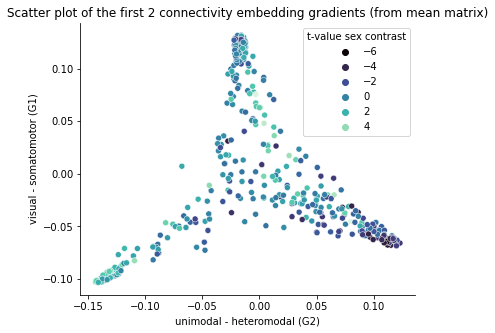

In [75]:
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=GSP_mean_fc_grad_comparable[:,1],  # all rows (400 parces), first column (G2: unimodal - heteromodal)
                     y=GSP_mean_fc_grad_comparable[:,0],  # all rows (400 parces), second column (G1: somatomotor/auditory - visual)  
                     hue=GSP_R_lm_G2_res.t_val_sex,  # gives color coding based on t value of sex contrast (main model including age, sex, icv)
                     palette=sns.color_palette("mako", as_cmap=True), 
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G2)');
ax.set_ylabel('visual - somatomotor (G1)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='t-value sex contrast')
plt.show(ax)

https://stackoverflow.com/questions/44641669/scatterplot-with-point-colors-representing-a-continuous-variable-in-seaborn-face problem of categorical coloring with hue >> solve to make continuous

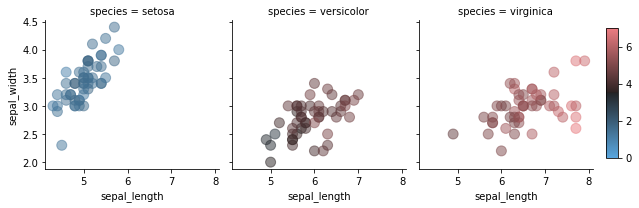

In [49]:
iris = sns.load_dataset('iris')
g = sns.FacetGrid(iris, col='species', palette = 'seismic')

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

vmin, vmax = 0, 7
cmap = sns.diverging_palette(240, 10, l=65, center="dark", as_cmap=True)

g = g.map(facet_scatter, 'sepal_length', 'sepal_width', "petal_length",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax, cmap=cmap)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

##### GIVEN THE PROBLEM WITH CATEGORICAL COLOR CODING, WAS TRYING TO DO A CONTINUOUS ONE FOLLOWING MARGULIES' CODE

but the color component of it does't work (see error below) - the only difference here with this jointplot is the addition of the histogram on axes

In [50]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

df = pd.DataFrame()
df['e0'] = np.array(mean_grad.gradients_[:,0])
df['e1'] = np.array(mean_grad.gradients_[:,1]) #* -1 # to reorient plot

In [51]:
import matplotlib.cm as cm
import matplotlib as mpl
# import matplotlib.pyplot as plt
# import pylab as plt
# from matplotlib.colors import ListedColormap
# mpl.rcParams['svg.fonttype'] = 'none'

norm_1 = mpl.colors.Normalize(vmin=df['e0'].min(), vmax=df['e0'].max())
cmap_1 = cm.Reds
map_1 = cm.ScalarMappable(norm=norm_1, cmap=cmap_1)

norm_2 = mpl.colors.Normalize(vmin=df['e1'].min(), vmax=df['e1'].max())
cmap_2 = cm.Greens
map_2 = cm.ScalarMappable(norm=norm_2, cmap=cmap_2)

norm_3 = mpl.colors.Normalize(vmin=df['e1'].max() * -1, vmax=df['e1'].min() * -1)
cmap_3 = cm.Blues
map_3= cm.ScalarMappable(norm=norm_3, cmap=cmap_3)

c = np.ones(map_1.to_rgba(df['e0']).shape)


a = df['e1'].copy()
a = a - a.min() 
a = a / a.max()
c[:,1] = a

a = df['e1'].copy() * -1
a = a - a.min() 
a = a / a.max()
c[:,2] = a

a = df['e0'].copy()
a = a - a.min() 
a = a / a.max()
c[:,0] = a
c[:,1] = c[:,1] * ((a - 1) *  -1)
c[:,2] = c[:,2] * ((a - 1) *  -1)

In [52]:
np.array(c)

array([[0.16589219, 0.10662289, 0.72748492, 1.        ],
       [0.59927073, 0.13959622, 0.26113305, 1.        ],
       [0.05849646, 0.04325878, 0.89824477, 1.        ],
       ...,
       [0.83238482, 0.07005999, 0.09755519, 1.        ],
       [0.95836653, 0.01590039, 0.02573307, 1.        ],
       [0.65085832, 0.14182363, 0.20731806, 1.        ]])

error
- use c argument if you want to feed numbers, use color argument if you want to feed words https://cumsum.wordpress.com/2021/09/19/matplotlibvalueerror-color-kwarg-must-be-an-color-or-sequence-of-color-specs-for-a-sequence-of-values-to-be-color-mapped-use-the-c-argument-instead/ 

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


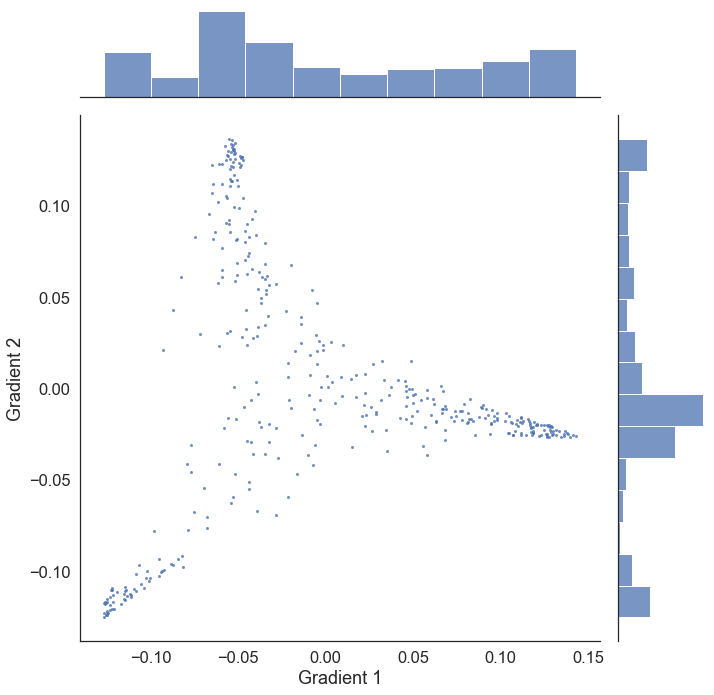

In [53]:
sns.set_context(font_scale=2)
g = sns.jointplot(x = 'e0', y = 'e1', data=df,
                  size=10, linewidth=0, marker='.', alpha=0.8,
                  

                  #c=np.array(c),  # ORIGINAL ARGUMENT
                  
                  #label='big',                   
                  #ylim = [np.min(df['e0']) - 0.5, np.max(df['e0']) + 0.5], 
                  #xlim = [np.min(df['e1']) - 0.5, np.max(df['e1']) + 0.5],
                  #stat_func=None)
                  )

g.set_axis_labels('Gradient 1', 'Gradient 2')

Margulies original code https://github.com/NeuroanatomyAndConnectivity/gradient_analysis/blob/master/03_visualize_embeddings.ipynb

In [ ]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

df = pd.DataFrame()
df['e0'] = np.array(emb[range(cortLen),0])
df['e1'] = np.array(emb[range(cortLen),1]) * -1 # to reorient plot

In [ ]:
import matplotlib.cm as cm

norm_1 = mpl.colors.Normalize(vmin=df['e0'].min(), vmax=df['e0'].max())
cmap_1 = cm.Reds
map_1 = cm.ScalarMappable(norm=norm_1, cmap=cmap_1)

norm_2 = mpl.colors.Normalize(vmin=df['e1'].min(), vmax=df['e1'].max())
cmap_2 = cm.Greens
map_2 = cm.ScalarMappable(norm=norm_2, cmap=cmap_2)

norm_3 = mpl.colors.Normalize(vmin=df['e1'].max() * -1, vmax=df['e1'].min() * -1)
cmap_3 = cm.Blues
map_3= cm.ScalarMappable(norm=norm_3, cmap=cmap_3)

c = np.ones(map_1.to_rgba(df['e0']).shape)

a = df['e1'].copy()
a = a - a.min() 
a = a / a.max()
c[:,1] = a

a = df['e1'].copy() * -1
a = a - a.min() 
a = a / a.max()
c[:,2] = a

a = df['e0'].copy()
a = a - a.min() 
a = a / a.max()
c[:,0] = a
c[:,1] = c[:,1] * ((a - 1) *  -1)
c[:,2] = c[:,2] * ((a - 1) *  -1)

In [ ]:
sns.set_context(font_scale=2)
g = (sns.jointplot('e1', 'e0', 
                   data=df, 
                   size=10, label='big', linewidth=0, marker='.', c=np.array(c), alpha=0.8,
                   ylim = [np.min(df['e0']) - 0.5, np.max(df['e0']) + 0.5], 
                   xlim=[np.min(df['e1']) - 0.5, np.max(df['e1']) + 0.5],
                   stat_func=None).set_axis_labels('Gradient 2', 'Gradient 1'))